## Text Modelling

The dataset is from an online discussion forum where members make posts about random sports topics and people engage in the topics, expressing their opinions as they see fit.   
The dataset comprises of post ID, post topic, the kind of audience targeted, time of post, post rating, total number of replies recorded on the post as of the time of fetching the data, the time of the first reply on the post, the time of the last reply on the post as of when the data was fetched and lastly a collection of all the text replies on the data of time the data was fetched.   

#### Goals and objectives
The goal of this analysis is **Topic Modelling**.   
1. At the end of the analysis, we should be able to discover at least the top 8 themes in the dataset.
2. Compare the post data top themes and reply data top themes
3. Compare the results of different models for the analysis and determine which is better.

To prepare the data after cleaning, I will be using both tokenisation and normalisation for data processing. Finally for model evaluation, I will be using the model metrics and coherence score for human interpretability. 

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata

In [2]:
df = pd.read_csv('sports_discussion.csv')
df.head()

,ID,post,audience,post_time,rating,total_reply,time_first_reply,time_last_reply,all_reply
0,334861113.0,Winning pitcher,R,7:45,NaN,0,NaN,NaN,NaN
1,334860171.0,The Three Greatest Martial Artists ever!,R,2025-05-23 23:51,-7,2,0:09,4:46,Bruce Lee never held any black belt** Chuck wa...
2,334858648.0,UFL Week 9,R,2025-05-23 17:11,-5,0,NaN,NaN,NaN
3,334857214.0,"so..angel reese is 6'3""...she is 4 for 19 when",R,2025-05-23 13:49,-5,4,2025-05-23 15:50,2025-05-23 21:20,"And? §** no and..can u add something cogent, m..."
4,334852374.0,"Caroline was the fav last night ,please explain",R,2025-05-23 06:20,NaN,1,2025-05-23 06:25,2025-05-23 06:25,Bobrovsky shutout imagine that §**


In [3]:
df.shape

(60000, 9)

Isolating only the two columns with text data for cleaning and analysis

In [4]:
sports = df[['post', 'all_reply']]
sports.head()

,post,all_reply
0,Winning pitcher,NaN
1,The Three Greatest Martial Artists ever!,Bruce Lee never held any black belt** Chuck wa...
2,UFL Week 9,NaN
3,"so..angel reese is 6'3""...she is 4 for 19 when","And? §** no and..can u add something cogent, m..."
4,"Caroline was the fav last night ,please explain",Bobrovsky shutout imagine that §**


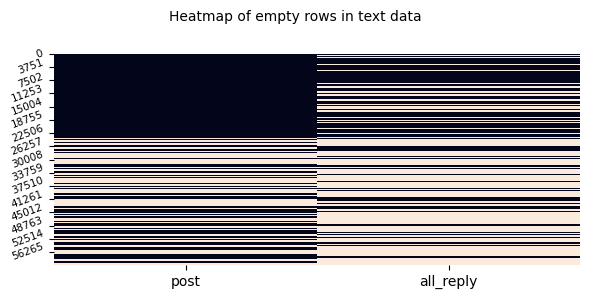

In [5]:
fig = plt.figure(figsize=(6, 3), layout='tight',)
plt.suptitle('Heatmap of empty rows in text data', size=10)
sns.heatmap(sports.isnull(),
            cbar=False)

plt.yticks(fontsize=7.5, rotation=20)

plt.show()

Based on the heatmap, we have quite a number of empty rows in the data especially for the all_reply column. I will proceed to find the percentage of that for each column and also  to convert these to pd.NA during data cleaning if they are not already so.

In [6]:
## percentage of null rows per column
post_null  = (100 * sports['post'].isnull().sum() / sports.shape[0]).round(2)
reply_null = (100 * sports['all_reply'].isnull().sum() / sports.shape[0]).round(2)

pd.DataFrame({'percentage_empty': [post_null, reply_null], 
              'name':['post', 'all_reply'],
              'total_rows': [60_000, 60_000],
             }).set_index('name')

,percentage_empty,total_rows
name,,
post,30.98,60000
all_reply,52.63,60000


Overall, approximately 53% of the rows in all_reply are np.nan and approximately 31% of the rows in post column are np.nan.  This percentage values have not considered empty strings or only white spaces.

#### Text cleaning 
In the text cleaning process of the rows, the following will be done
1. Keep all empty rows as empty and convert empty strings at Nan
2. ensure that all text is converted to canonical forms
3. all non-unicode characters will be stripped and text converted to lower case and returned
4. hyphenated words or possesive nouns (ie apostrophy) will be retained 

In [7]:
## cleaning the text rows of the data 
pattern = re.compile(r"[^\W\d_]+(?:['-][^\W\d_]+)*|\d+", flags=re.UNICODE)

## function to clean the text strings

def clean_str(text, pattern):
    """ this functions cleans the text strings """
    if isinstance(text, float):  # checks if a row is nan and returns it
        return text 
        
    text = unicodedata.normalize('NFKC', text)
    
    words = pattern.findall(text)
    if len(words) < 1: # checks if empty list is returned from pattern search
        return pd.NA
        
    return ' '.join(words).lower()


In [8]:
## before cleaning 
sports.head()

,post,all_reply
0,Winning pitcher,NaN
1,The Three Greatest Martial Artists ever!,Bruce Lee never held any black belt** Chuck wa...
2,UFL Week 9,NaN
3,"so..angel reese is 6'3""...she is 4 for 19 when","And? §** no and..can u add something cogent, m..."
4,"Caroline was the fav last night ,please explain",Bobrovsky shutout imagine that §**


In [9]:
### updating the columns 
sports_clean = sports.copy()

for column in sports_clean.columns:
    sports_clean.loc[:, column] = sports_clean[column].apply(clean_str, args=(pattern,))

## after cleaning
sports_clean.head()

,post,all_reply
0,winning pitcher,NaN
1,the three greatest martial artists ever,bruce lee never held any black belt chuck was ...
2,ufl week 9,NaN
3,so angel reese is 6 3 she is 4 for 19 when,and no and can u add something cogent mr shang...
4,caroline was the fav last night please explain,bobrovsky shutout imagine that


In [10]:
sports.tail()

,post,all_reply
59995,NaN,^deeply cut bitch boy §** top posting = you l...
59996,Wednesday Free Sports Picks - MLB + NBA + NHL,NaN
59997,Question.. if the entire NFL season is wiped out,NaN
59998,Wrigley is a beaut,Yeah I traveled all the way to Chicago** Lots ...
59999,49ers hope at QB . . . is Alex Smith?,I think I understand the approach**


In [11]:
sports_clean.tail()

,post,all_reply
59995,NaN,deeply cut bitch boy top posting you lose
59996,wednesday free sports picks mlb nba nhl,NaN
59997,question if the entire nfl season is wiped out,NaN
59998,wrigley is a beaut,yeah i traveled all the way to chicago lots of...
59999,49 ers hope at qb is alex smith,i think i understand the approach


In [12]:
## Double checking if there is any changes to the percentage of empty rows

cleaned_post_null  = (100 * sports_clean['post'].isnull().sum() / sports_clean.shape[0]).round(2)
cleaned_reply_null = (100 * sports_clean['all_reply'].isnull().sum() / sports_clean.shape[0]).round(2)

pd.DataFrame({'percentage_empty': [cleaned_post_null, cleaned_reply_null], 
              'name':['post', 'all_reply'],
              'total_rows': [60_000, 60_000],
             }).set_index('name')

,percentage_empty,total_rows
name,,
post,31.00,60000
all_reply,52.67,60000


The data cleaning stage of the text columns have shown that some rows ended up as empty rows which is evidenced with the increase in the the percentage of the empty rows. 

#### Data Preparation for modelling 
Because there are a lot of empty rows in the data, these rows need to be dropped as they represent no entry. Based on my objectives above, one of the objectives was to compare the themes in the post versus replies. Therefore I will prepare the dataset into three parts. One part will be to stack the post and reply columns as a single column, that way all the entire data is captured and the empty rows will be dropped.  The other part will be to separate the post and reply as different datasets and then model each separately to get the themes in the data. 

In [13]:
### Separating the post and reply column 
post = sports_clean[['post']].dropna().reset_index(drop=True)
reply = sports_clean[['all_reply']].dropna().reset_index(drop=True)

display(post.isnull().sum())
display(reply.isnull().sum())

post    0
dtype: int64

all_reply    0
dtype: int64

In [14]:
display(post.shape)
display(reply.shape)

(41399, 1)

(28399, 1)

In [15]:
# combining post and reply into one column
combined = pd.concat([post['post'], reply['all_reply']], axis=0, ignore_index=True)
combined = combined.dropna().reset_index(drop=True)
combined = pd.DataFrame(combined)
combined.rename(columns={0:'all_posts'}, inplace=True)
combined.shape

(69798, 1)

In [16]:
combined.head()

,all_posts
0,winning pitcher
1,the three greatest martial artists ever
2,ufl week 9
3,so angel reese is 6 3 she is 4 for 19 when
4,caroline was the fav last night please explain


In [17]:
combined.tail()

,all_posts
69793,derby easily haven't been to either i'll take ...
69794,yeah he was the reason the mavs shooters so yo...
69795,deeply cut bitch boy top posting you lose
69796,yeah i traveled all the way to chicago lots of...
69797,i think i understand the approach


### Model Tuning and parameter selections
In this stage, I am going prepare the data in two ways, one by CountVectorizer  which uses only term frequency and the other TFidfVectorizer uses both inverse term frequency and normalization.   The CountVectorizer only considers the count of words in the document but TfidfVectorizer considers the frequency and the inverse frequency in the entire document.   

Next is that i intend compare two models with the prepared data, first model is Non-Negative Matrix Factorization (NMF) and the other Latent Dirichlet Allocation (LDA).  Because this is an unsupervised learning, I will be tuning the models manually but will be using a vectorized data from TfidfVectorizer.  The reason for this training was because Tfidfvectorizer gives a truer representation of the document as it weighs each term with respect to the entire document.  The training of both models will be minimalist and I will be using sparsity and reconstruction error of NMF models results, perplexity and log-likelihood error of LDA model in addition to the coherence-results of the model to choose the final model for the prepared data.   
Coherence of the topics from the model is particularly important for human interpretability because the goal of this work is **Topic Modelling**.  


In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from collections import defaultdict
import time
from sklearn.model_selection import ParameterGrid
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [19]:
## I have decided to put this process of vectorisation, model tunning and coherence calculation into object
class FeatureEngineer:

    def __init__(self, vectorizer, X, nmf_param=None, lda_param=None, ngrams=1, seed=181):
        self.vectorizer = vectorizer
        self.X = X
        self.ngram = ngrams
        self.nmf_param = nmf_param
        self.lda_param = lda_param
        self.seed = seed

    @property
    def vectorize_X(self):
        """This function turns the corpus into a vector
        """
        self.vect = self.vectorizer(token_pattern=r"(?u)\b\w\w+(?:-\w+)*\b",
                          ngram_range = (1, self.ngram),
                          min_df=5, max_df=0.8,
                          stop_words='english')
        
        self.X_tf = self.vect.fit_transform(self.X)
        self.feature_names = self.vect.get_feature_names_out()
        self.totals =np.asarray(self.X_tf.sum(axis=0)).ravel()
        self.top_10 = self.totals.argsort()[::-1][:10]
        self.top_word_counts = list(zip(self.feature_names[self.top_10], self.totals[self.top_10]))
    
        return self.X_tf, self.top_word_counts, self.vect


    @property
    def NMF_param_tune(self):
        """This functions does a manual grid search 
        for parameters for the NMF model 
        """
        self.X_tf, _, self.vect = self.vectorize_X
        
        self.results = defaultdict(list)
        
        for param in ParameterGrid(self.nmf_param):
            self.start_t0 = time.time()
            self.model = NMF(n_components=param['n_components'], 
                        init='nndsvd',
                        solver='cd',
                        beta_loss='frobenius',
                        alpha_W = param['alpha_W'],
                        alpha_H = param['alpha_H'],
                        l1_ratio = param['l1_ratio'],
                        random_state = self.seed
                       )
    
            self.W = self.model.fit_transform(self.X_tf)
            self.H = self.model.components_
            self.component = param['n_components']
    
            self.results['params'].append(self.nmf_param)
            self.results['n_components'].append(self.component)
            self.results['reconstruction_error'].append(self.model.reconstruction_err_)
            self.results['sparsity_W'].append((self.W==0).sum() / self.W.size)
            self.results['sparsity_H'].append((self.H==0).sum() / self.H.size)
            self.results['model'].append(self.model)
            self.stop_t1 = time.time()
            self.results['time_secs'].append(self.stop_t1 - self.start_t0)
            
        return pd.DataFrame(self.results)

    @property
    def lda_tuning(self):
        """ This function tunes the LDA model"""

        self.X_tf, _, self.vect = self.vectorize_X
    
        self.results = defaultdict(list)
        self.start_t0 = time.time()
        for param in ParameterGrid(self.lda_param):
            self.model = LDA(
                n_components=param['n_components'],
                max_iter = param['max_iter'],
                learning_method = 'batch',
                random_state = self.seed,
                n_jobs = -1
            )
    
            self.model.fit(self.X_tf)
            self.results['params'].append(param)
            self.results['perplexity'].append(self.model.perplexity(self.X_tf))
            self.results['log_likelihood'].append(self.model.score(self.X_tf))
            self.results['model'].append(self.model)
            self.stop_t1 = time.time()
            self.results['time_secs'].append(self.stop_t1 - self.start_t0)
    
        return pd.DataFrame(self.results)

class CoherentAndPlot(FeatureEngineer):

    def __init__(self, vectorizer, X, models, nrows=None, ncols=None, title=None, plot=False, calc_coherence=True):
        super().__init__(vectorizer, X, ngrams=1,)
        self.models = models
        self.nrows = nrows
        self.ncols = ncols
        self.title = title
        self.plot = plot
        self.calc_coherence = calc_coherence
       
    
    @property
    def construct_coherence(self):
        """ This model calculates the coherence of all the models
        and also plots the top 10 topics from the model
        """
        self.X_tf, _, self.vect = self.vectorize_X
        
        self.model_coherence = defaultdict(list)
        
        if self.calc_coherence:
            self.token_docs = [docs.split() for docs in self.X]
            self.token_dict = Dictionary(self.token_docs)
           
        if self.plot:
            self.fig, self.axes = plt.subplots(self.nrows, self.ncols, figsize=(30, 15), sharex=True)
            self.axes = axes.flatten()
        
        for model in self.models:
            self.topic_results = []
            for topic_idx, topic in enumerate(model.components_):
                self.top_topic_index = topic.argsort()[-10:]
                self.top_feature_names = self.vect.get_feature_names_out()[self.top_topic_index]
                self.weights = topic[self.top_topic_index]
                self.topic_results.append(self.top_feature_names)
                
                if self.plot:
                    self.ax = self.axes[topic_idx]
                    self.ax.barh(y = self.top_feature_names, 
                            width= self.weights,
                            height= 0.7,
                           )
                    self.ax.set_title(f'Topic {topic_idx+1}', fontdict={"fontsize": 30}),
                    self.ax.tick_params(axis='both',which='major', labelsize=12)
                    for pos in 'top right left'.split():
                        self.ax.spines[pos].set_visible(False)
    
                    plt.suptitle(self.title)
                    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
                    plt.show()
    
            if self.calc_coherence:
                self.cm = CoherenceModel(topics=self.topic_results,
                                        texts=self.token_docs,
                                        dictionary=self.token_dict,
                                        coherence='c_v'
                                       )
                
                self.model_cm = self.cm.get_coherence()
                self.model_coherence['model'].append(model)
                self.model_coherence['coherence'].append(self.model_cm)   
                
        return pd.DataFrame(self.model_coherence)
            
        
def plot_reconstruction_error(errors, components):
    """ This function plots the reconstruction error from NMF model
    or the perplexity and likelihood of LDA
    """
    plt.figure(figsize=(5, 5))
    plt.plot(components, errors, 'bo-')
    plt.xlabel('Number of topics')
    plt.ylabel('Reconstruction error')
    plt.title('NMF: reconstruction error vs number of topics')
    plt.grid(True, alpha = 0.3)
    plt.show()
        

In [20]:
## Setting parameters for tuning the models

param_grid_nmf = {
    'n_components': [5, 8, 10, 12],
    'alpha_W': [0.0, 0.1, 0.5],  
    'alpha_H': [0.0, 0.1, 0.5],
    'l1_ratio': [0.0, 0.5, 1.0],
}


X=combined['all_posts']

nmf_model_vectorizer = FeatureEngineer(vectorizer=TfidfVectorizer,
                            X=X,
                            nmf_param=param_grid_nmf,
                           )

# Vectorizing X 
x_tf, top_words, vect_model = nmf_model_vectorizer.vectorize_X


In [21]:
## tuning the NMF Model
tuned_nmf = nmf_model_vectorizer.NMF_param_tune

C:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1

In [22]:
## looking at the top 10 models
tuned_nmf.head(10)

,params,n_components,reconstruction_error,sparsity_W,sparsity_H,model,time_secs
0,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",5,259.548987,0.473237,0.484076,"NMF(alpha_H=0.0, init='nndsvd', n_components=5...",0.795783
1,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",8,258.451503,0.438677,0.482800,"NMF(alpha_H=0.0, init='nndsvd', n_components=8...",0.867906
2,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,257.800085,0.431156,0.496181,"NMF(alpha_H=0.0, init='nndsvd', n_components=1...",3.746031
3,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",12,257.162487,0.465877,0.528858,"NMF(alpha_H=0.0, init='nndsvd', n_components=1...",1.539346
4,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",5,259.548987,0.473237,0.484076,"NMF(alpha_H=0.0, init='nndsvd', l1_ratio=0.5, ...",0.812191
5,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",8,258.451503,0.438677,0.482800,"NMF(alpha_H=0.0, init='nndsvd', l1_ratio=0.5, ...",0.902887
6,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,257.800085,0.431156,0.496181,"NMF(alpha_H=0.0, init='nndsvd', l1_ratio=0.5, ...",2.829104
7,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",12,257.162487,0.465877,0.528858,"NMF(alpha_H=0.0, init='nndsvd', l1_ratio=0.5, ...",1.374729
8,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",5,259.548987,0.473237,0.484076,"NMF(alpha_H=0.0, init='nndsvd', l1_ratio=1.0, ...",0.801497
9,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",8,258.451503,0.438677,0.482800,"NMF(alpha_H=0.0, init='nndsvd', l1_ratio=1.0, ...",0.875875


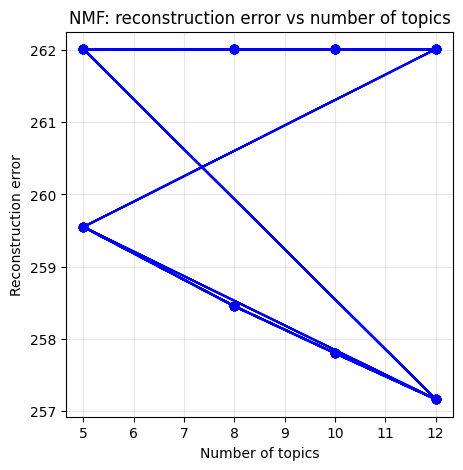

In [23]:
## plotting the reconstruction error of the models
plot_reconstruction_error(tuned_nmf['reconstruction_error'], tuned_nmf['n_components'])

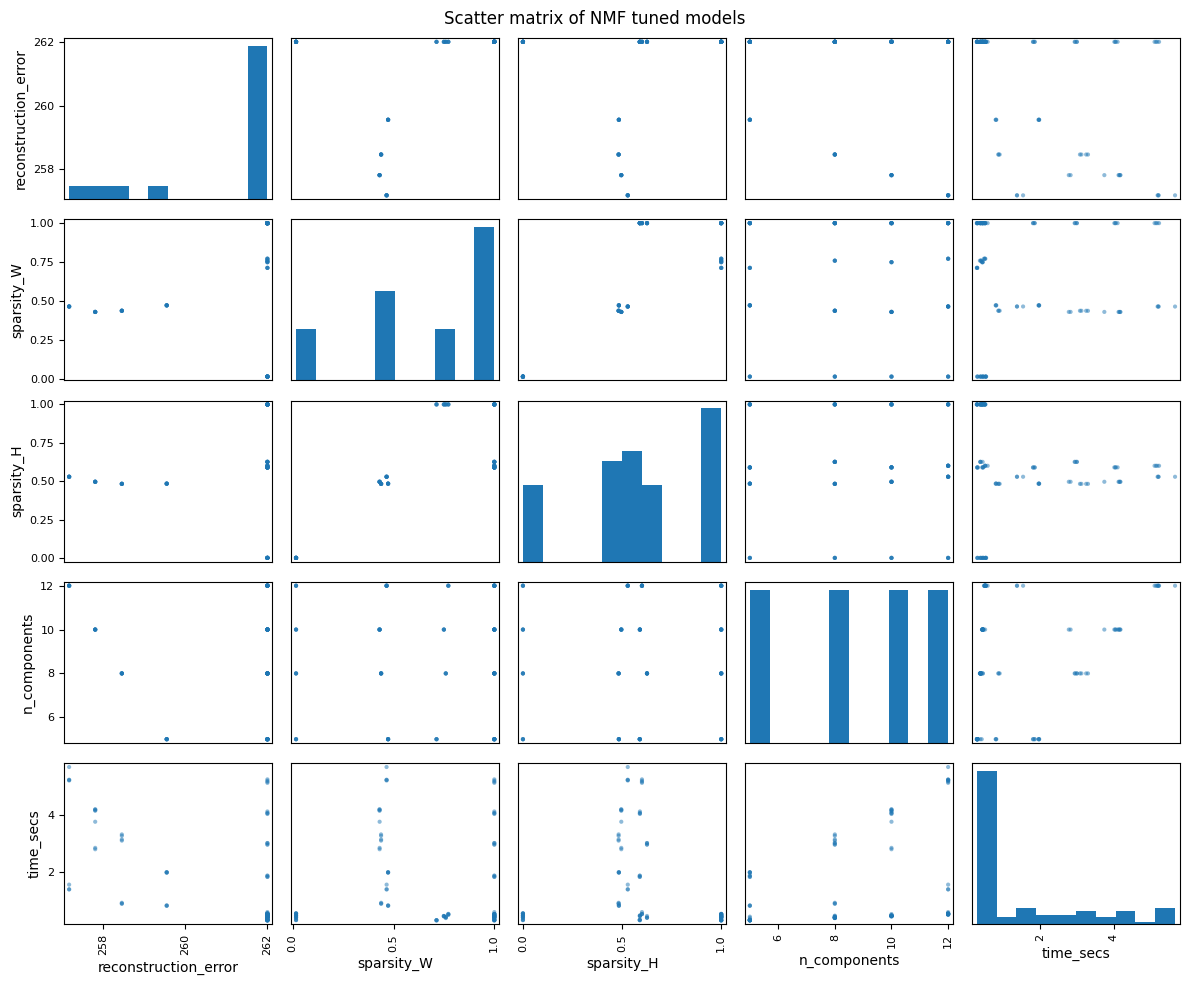

In [24]:
## plotting the scatter matrix of the nmf tuned models
pd.plotting.scatter_matrix(tuned_nmf[['reconstruction_error', 'sparsity_W', 'sparsity_H', 'n_components', 'time_secs']],
                           figsize=(12, 10)
                          )
plt.suptitle('Scatter matrix of NMF tuned models')
plt.tight_layout()
plt.show()

Based on the scatter matrix, the reconstruction errors has a diminishing returns as the n-components increases. There is an improvement from 5 to 12 but beyond 10, there is no much improvement.  At 10 also, the models maintain a good sparsity for topics (H) and distictiveness (W). One more thing before deciding on the model will be to look at the coherence of the topics at 10.  Also, at 10 n-components there are a range of sparsity values and to maintain a good sparsity for the data, I will set a threshold of where the sparsity is greater than 50% of all sparsity matrix and runtime is less than 4 seconds

In [25]:
### computing results
sparsity_W_threshold = np.percentile(np.asarray(tuned_nmf['sparsity_W']), 50)
sparsity_H_threshold = np.percentile(np.asarray(tuned_nmf['sparsity_H']), 50)
time_threshold = tuned_nmf['time_secs'] < 4.0
component_threshold = tuned_nmf['n_components']==10

nmf_result_filter = (tuned_nmf['sparsity_W'] >= sparsity_W_threshold) & (tuned_nmf['sparsity_H'] >= (sparsity_H_threshold))
nmf_threshold = tuned_nmf[nmf_result_filter&time_threshold&component_threshold]
nmf_filtered =  nmf_threshold.reset_index(drop=True)
nmf_filtered

,params,n_components,reconstruction_error,sparsity_W,sparsity_H,model,time_secs
0,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,0.589979,"NMF(alpha_H=0.0, alpha_W=0.1, init='nndsvd', l...",0.462776
1,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,0.589979,"NMF(alpha_H=0.0, alpha_W=0.1, init='nndsvd', l...",0.432467
2,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,0.589979,"NMF(alpha_H=0.0, alpha_W=0.5, init='nndsvd', l...",0.442125
3,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,0.589979,"NMF(alpha_H=0.0, alpha_W=0.5, init='nndsvd', l...",0.446572
4,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,1.000000,"NMF(alpha_H=0.1, alpha_W=0.1, init='nndsvd', l...",0.457550
5,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,1.000000,"NMF(alpha_H=0.1, alpha_W=0.5, init='nndsvd', l...",0.439565
6,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,1.000000,"NMF(alpha_H=0.5, alpha_W=0.1, init='nndsvd', l...",0.425567
7,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,1.000000,"NMF(alpha_H=0.5, alpha_W=0.5, init='nndsvd', l...",0.441935


In [26]:
## tuning LDA models 
param_grid_lda = {
    'n_components': [5, 8, 10, 12], # tunning only these because LDA is typically slow
    'max_iter':[10, 25],
    
}
lda_model_vectorizer = FeatureEngineer(vectorizer=CountVectorizer,
                            X=X,
                            lda_param=param_grid_lda)

# Vectorizing X 
x_tf, lda_top_words, lda_vect_model = lda_model_vectorizer.vectorize_X

tuned_lda = lda_model_vectorizer.lda_tuning

In [27]:
# displaying the tune results for the LDA models
tuned_lda

,params,perplexity,log_likelihood,model,time_secs
0,"{'max_iter': 10, 'n_components': 5}",3588.598291,-3.913512e+06,"LatentDirichletAllocation(n_components=5, n_jo...",57.049101
1,"{'max_iter': 10, 'n_components': 8}",3821.687052,-3.943599e+06,"LatentDirichletAllocation(n_components=8, n_jo...",107.847153
2,"{'max_iter': 10, 'n_components': 10}",3904.954411,-3.953904e+06,"LatentDirichletAllocation(n_jobs=-1, random_st...",158.426296
3,"{'max_iter': 10, 'n_components': 12}",4065.965952,-3.973222e+06,"LatentDirichletAllocation(n_components=12, n_j...",208.217849
4,"{'max_iter': 25, 'n_components': 5}",3443.681794,-3.893804e+06,"LatentDirichletAllocation(max_iter=25, n_compo...",287.422743
5,"{'max_iter': 25, 'n_components': 8}",3652.815099,-3.921992e+06,"LatentDirichletAllocation(max_iter=25, n_compo...",364.461632
6,"{'max_iter': 25, 'n_components': 10}",3726.101357,-3.931489e+06,"LatentDirichletAllocation(max_iter=25, n_jobs=...",439.469861
7,"{'max_iter': 25, 'n_components': 12}",3837.785587,-3.945609e+06,"LatentDirichletAllocation(max_iter=25, n_compo...",514.322517


Based on the overall tuned LDA models results, there is an improvement with an increase in the number of iterations from 10 to 25 although this comes at the cost of training times.  The log-likelihood is monotonically increasing with increase in components for each iteration number and same is observed for perplexity.  Although these results are not what is expected however, it clearly shows that the results from the 25 iterations are better than 10 iterations. The next step is to evaluate the coherence of topics from these models to determine the most interpretable model for analysis.

In [28]:
## coherent calculations  

lda_model_list = tuned_lda['model'].tolist()
nmf_model_list = nmf_filtered['model'].tolist() # using the filtered models only for NMF

lda_constructor_ = CoherentAndPlot(vectorizer=TfidfVectorizer,
                                   X=X,
                                   models=lda_model_list)

tuned_lda_coherence = lda_constructor_.construct_coherence

nmf_constructor_ = CoherentAndPlot(vectorizer=TfidfVectorizer,
                                   X=X,
                                   models=nmf_model_list)

tuned_nmf_coherence = nmf_constructor_.construct_coherence

In [29]:
## displaying coherence results for the tuned LDA models
tuned_lda_coherence

,model,coherence
0,"LatentDirichletAllocation(n_components=5, n_jo...",0.567472
1,"LatentDirichletAllocation(n_components=8, n_jo...",0.547125
2,"LatentDirichletAllocation(n_jobs=-1, random_st...",0.567223
3,"LatentDirichletAllocation(n_components=12, n_j...",0.553959
4,"LatentDirichletAllocation(max_iter=25, n_compo...",0.578682
5,"LatentDirichletAllocation(max_iter=25, n_compo...",0.580168
6,"LatentDirichletAllocation(max_iter=25, n_jobs=...",0.546483
7,"LatentDirichletAllocation(max_iter=25, n_compo...",0.568200


In [30]:
## combining results for LDA
complete_lda = tuned_lda.merge(tuned_lda_coherence, on='model')
complete_lda

,params,perplexity,log_likelihood,model,time_secs,coherence
0,"{'max_iter': 10, 'n_components': 5}",3588.598291,-3.913512e+06,"LatentDirichletAllocation(n_components=5, n_jo...",57.049101,0.567472
1,"{'max_iter': 10, 'n_components': 8}",3821.687052,-3.943599e+06,"LatentDirichletAllocation(n_components=8, n_jo...",107.847153,0.547125
2,"{'max_iter': 10, 'n_components': 10}",3904.954411,-3.953904e+06,"LatentDirichletAllocation(n_jobs=-1, random_st...",158.426296,0.567223
3,"{'max_iter': 10, 'n_components': 12}",4065.965952,-3.973222e+06,"LatentDirichletAllocation(n_components=12, n_j...",208.217849,0.553959
4,"{'max_iter': 25, 'n_components': 5}",3443.681794,-3.893804e+06,"LatentDirichletAllocation(max_iter=25, n_compo...",287.422743,0.578682
5,"{'max_iter': 25, 'n_components': 8}",3652.815099,-3.921992e+06,"LatentDirichletAllocation(max_iter=25, n_compo...",364.461632,0.580168
6,"{'max_iter': 25, 'n_components': 10}",3726.101357,-3.931489e+06,"LatentDirichletAllocation(max_iter=25, n_jobs=...",439.469861,0.546483
7,"{'max_iter': 25, 'n_components': 12}",3837.785587,-3.945609e+06,"LatentDirichletAllocation(max_iter=25, n_compo...",514.322517,0.568200


In [31]:
## displaying coherence results for the tuned NMF models
tuned_nmf_coherence

,model,coherence
0,"NMF(alpha_H=0.0, alpha_W=0.1, init='nndsvd', l...",0.530359
1,"NMF(alpha_H=0.0, alpha_W=0.1, init='nndsvd', l...",0.530359
2,"NMF(alpha_H=0.0, alpha_W=0.5, init='nndsvd', l...",0.530359
3,"NMF(alpha_H=0.0, alpha_W=0.5, init='nndsvd', l...",0.530359
4,"NMF(alpha_H=0.1, alpha_W=0.1, init='nndsvd', l...",0.517501
5,"NMF(alpha_H=0.1, alpha_W=0.5, init='nndsvd', l...",0.517501
6,"NMF(alpha_H=0.5, alpha_W=0.1, init='nndsvd', l...",0.517501
7,"NMF(alpha_H=0.5, alpha_W=0.5, init='nndsvd', l...",0.517501


In [32]:
### Combining the NMF coherence with nmf_filtered
nmf_filtered_results = tuned_nmf_coherence.merge(nmf_filtered, on='model')
nmf_filtered_results

,model,coherence,params,n_components,reconstruction_error,sparsity_W,sparsity_H,time_secs
0,"NMF(alpha_H=0.0, alpha_W=0.1, init='nndsvd', l...",0.530359,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,0.589979,0.462776
1,"NMF(alpha_H=0.0, alpha_W=0.1, init='nndsvd', l...",0.530359,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,0.589979,0.432467
2,"NMF(alpha_H=0.0, alpha_W=0.5, init='nndsvd', l...",0.530359,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,0.589979,0.442125
3,"NMF(alpha_H=0.0, alpha_W=0.5, init='nndsvd', l...",0.530359,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,0.589979,0.446572
4,"NMF(alpha_H=0.1, alpha_W=0.1, init='nndsvd', l...",0.517501,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,1.000000,0.457550
5,"NMF(alpha_H=0.1, alpha_W=0.5, init='nndsvd', l...",0.517501,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,1.000000,0.439565
6,"NMF(alpha_H=0.5, alpha_W=0.1, init='nndsvd', l...",0.517501,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,1.000000,0.425567
7,"NMF(alpha_H=0.5, alpha_W=0.5, init='nndsvd', l...",0.517501,"{'n_components': [5, 8, 10, 12], 'alpha_W': [0...",10,262.01145,1.0,1.000000,0.441935


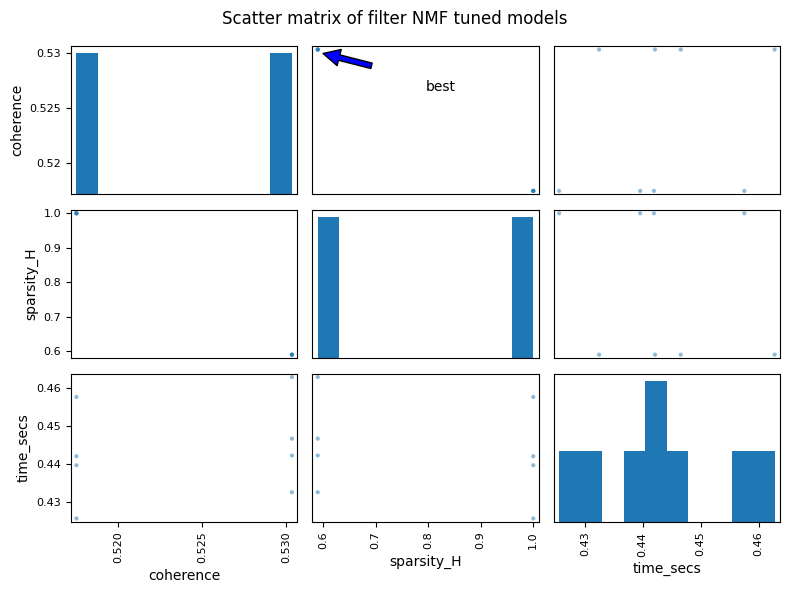

In [33]:
## plotting the scatter matrix of the filtered nmf tuned models
matrix = pd.plotting.scatter_matrix(nmf_filtered_results[['coherence', 'sparsity_H', 'time_secs']],
                           figsize=(8, 6)
                          )
plt.suptitle('Scatter matrix of filter NMF tuned models')
plot = matrix[0][1]
plot.annotate('best', xy=(0.6, 0.53), xycoords='data', 
              xytext=(0.5, 0.7), textcoords='axes fraction',
              arrowprops=dict(facecolor='b', shrink=0.5))

plt.tight_layout()
plt.show()

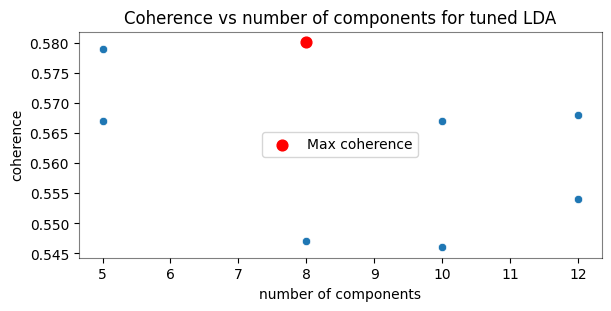

In [34]:
### plotting scatter matrix of tuned LDA results
lda_components = [5, 8, 10, 12, 5, 8, 10, 12]
max_value = max(tuned_lda_coherence['coherence'])
fig, ax = plt.subplots(figsize=(6, 3), layout='constrained')

sns.scatterplot(x=lda_components, y=tuned_lda_coherence['coherence'].round(3), ax=ax)
ax.scatter(x=lda_components[5], y=max_value, color='r', s=60, label='Max coherence')
ax.set_xlabel('number of components')
ax.set_title('Coherence vs number of components for tuned LDA')
ax.spines[:].set_alpha(0.5)
plt.legend(loc='center')
plt.show()


#### Summary for tuned models
Following coherence calculations for the NMF and LDA tuned models, the best model for the LDA is the model with 8 components and maximum iteration of 25. This corresponds to the tuned-lda-coherence model with index 5.  
The maximum coherence score was similar for a number of the filtered tuned NMF models. All of the models have 10 components and sparsity_W of 1. The sparsity_H was also between 0.6 and 1 for the models. The main difference comes from the training times.  Putting all of these together and choosing models where all the sparsities are not to the extreme, the coherence is highest and the training time is minimum, the model that meets these is the model with index 3 from the nmf-filtered-results.   

In [35]:
### best LDA model
best_LDA  = tuned_lda_coherence['model'][5]
display(tuned_lda_coherence.iloc[5])
best_LDA

model        LatentDirichletAllocation(max_iter=25, n_compo...
coherence                                             0.580168
Name: 5, dtype: object

LatentDirichletAllocation(max_iter=25, n_components=8, n_jobs=-1,
                          random_state=181)

In [36]:
### best NMF model 
best_NMF = nmf_filtered_results['model'][3]
display(nmf_filtered_results.iloc[3])
best_NMF

model                   NMF(alpha_H=0.0, alpha_W=0.5, init='nndsvd', l...
coherence                                                        0.530359
params                  {'n_components': [5, 8, 10, 12], 'alpha_W': [0...
n_components                                                           10
reconstruction_error                                            262.01145
sparsity_W                                                            1.0
sparsity_H                                                       0.589979
time_secs                                                        0.446572
Name: 3, dtype: object

NMF(alpha_H=0.0, alpha_W=0.5, init='nndsvd', l1_ratio=1.0, n_components=10,
    random_state=181)

### Topic modelling 
Using the two models chosen, i will model the prepared data and compare the topics across the models with the prepared data. 

The data will be prepared as unigram and bigram using countvectorizer, and then as unigram and bigram using TfidfVectorizer.  

For each model, the metrics evaluated will be for NMF (1) reconstruction error (2) coherence score and for LDA (1) log-likelihood (2) perplexity (3) coherence score where applicable.  

In [38]:
## vectorizer and model definitions 

model_results = defaultdict(list)

def generate_token(corpus):
    """generate tokens for coherence"""
    token_docs = [docs.split() for docs in corpus]
    token_dict = Dictionary(token_docs)
    return token_docs, token_dict
    

def vectorizer_x(X, vectorizer, ngram):
    """ this prepares the documents"""
    vect = vectorizer(token_pattern=r"(?u)\b\w\w+(?:-\w+)*\b",
                      ngram_range = (1, ngram),
                      min_df=5, max_df=0.8,
                      stop_words='english')
    X_tf = vect.fit_transform(X)
    return X_tf, vect


def model_fit(model, X, vect, token_docs, token_dict):
    
    """fitting the models function and compute coherence score"""
    start_t0 = time.time()
    model.fit(X)
    model_results['model'].append(model.__class__.__name__)
    model_results['vectorizers'].append(vect.__class__.__name__)
    model_results['ngrams'].append(vect.ngram_range)
    
    topic_results = []
    component_topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_topic_index = topic.argsort()[-10:]
        top_feature_names = vect.get_feature_names_out()[top_topic_index]
        topic_results.append(top_feature_names)

        component_topics[f"Topic_{topic_idx+1}"] = ([topic[top_topic_index], top_feature_names])
            
    cm = CoherenceModel(topics=topic_results, texts=token_docs, dictionary=token_dict, coherence='c_v')
    model_cm = cm.get_coherence()
    model_results['coherence'].append(model_cm)   

    if hasattr(model, 'reconstruction_err_'):
        model_results['reconstruction_error'].append(model.reconstruction_err_)

    if hasattr(model, 'perplexity'):
        model_results['perplexity'].append(model.perplexity(X))
        model_results['log_likelihood'].append(model.score(X))

    model_results['top_topics'].append(component_topics)
    
    stop_t1 = time.time()
    model_results['time_secs'].append(stop_t1 - start_t0)


def plot_top_results(model_topics, nrows=None, ncols=None, title=None):    
    """plot the model topics"""
    fig, axes = plt.subplots(nrows, ncols, figsize=(25, 10), sharex=True)
    axes = axes.flatten()
    num=0
    for key, values in model_topics.items():
        weights = values[0]
        words = values[1]
        ax = axes[num]
        ax.barh(y = words, width= weights, height= 0.5)
        
        ax.set_title(f'{key}', fontdict={"fontsize": 14}),
        ax.tick_params(axis='both',which='major', labelsize=12)
                
        for pos in 'top right left'.split():
                ax.spines[pos].set_visible(False)

        num += 1

    plt.suptitle(title, fontsize=20, color='red', fontweight='bold')
    plt.subplots_adjust(top=0.9, bottom=0.09, wspace=0.30, hspace=0.2)
    plt.show()

        
            

In [39]:
#prepared text data
X = combined['all_posts']
# generating tokens 
token_docs, token_dict = generate_token(X)

grams = [1, 2]
vectorizers = [CountVectorizer, TfidfVectorizer]

#preparing NMF model data
vectorised_nmf_data = []

for tokenizer in vectorizers:
    for gram in grams:
        X_tf, vect = vectorizer_x(X=X, vectorizer=tokenizer, ngram=gram)
        vectorised_nmf_data.append((X_tf, vect))


#preparing LDA model data
vectorised_lda_data = []

for gram in grams:
    X_tf, vect = vectorizer_x(X=X, vectorizer=CountVectorizer, ngram=gram)
    vectorised_lda_data.append((X_tf, vect))

In [40]:
## running the models
#nmf model
for X_, v_ in vectorised_nmf_data:
    model_fit(model = best_NMF, 
            X = X_,
            vect = v_,
            token_docs = token_docs,
            token_dict = token_dict)


#lda model
for X_, v_ in vectorised_lda_data:
    model_fit(model = best_LDA, 
            X = X_,
            vect = v_,
            token_docs = token_docs,
            token_dict = token_dict)

In [41]:
import copy

result_keys = ['model', 'vectorizers', 'ngrams', 'coherence', 'time_secs']
model_specific_keys = ['reconstruction_error', 'perplexity', 'log_likelihood']
plot_keys = ['model', 'vectorizers', 'ngrams', 'top_topics']

In [42]:
##Tabulating the results
fitted_model_results = {}
model_specific = {}

for key1 in result_keys:
    fitted_model_results[key1] = copy.deepcopy(model_results[key1])

for key2 in model_specific_keys:
    model_specific[key2] = copy.deepcopy(model_results[key2])
    #print(model_results[key2])

for i in range(2):
    model_specific['reconstruction_error'].append(np.nan) # making up the rows for LDA model with nan for reconstruction error

for i in range(4):
    model_specific['perplexity'].insert(i, np.nan) # making up the rows for NMF model with nan 
    model_specific['log_likelihood'].insert(i, np.nan)
    
model_final_results = pd.concat([pd.DataFrame(fitted_model_results), pd.DataFrame(model_specific)], axis=1)
model_final_results=model_final_results.set_index('model')
model_final_results

,vectorizers,ngrams,coherence,time_secs,reconstruction_error,perplexity,log_likelihood
model,,,,,,,
NMF,CountVectorizer,"(1, 1)",0.623988,11.579529,734.073566,NaN,NaN
NMF,CountVectorizer,"(1, 2)",0.677177,11.633306,778.713041,NaN,NaN
NMF,TfidfVectorizer,"(1, 1)",0.530359,12.724897,262.011450,NaN,NaN
NMF,TfidfVectorizer,"(1, 2)",0.555243,12.173122,262.011450,NaN,NaN
LatentDirichletAllocation,CountVectorizer,"(1, 1)",0.580168,92.273344,NaN,3652.815099,-3.921992e+06
LatentDirichletAllocation,CountVectorizer,"(1, 2)",0.588813,88.452317,NaN,5230.020022,-4.647871e+06


In [43]:
#tabulating the plot results
plot_results = {}
for key in plot_keys:
    #plot_results.append(copy.deepcopy(model_results[key]))
    plot_results[key] = copy.deepcopy(model_results[key])
    
plot_results = pd.DataFrame(plot_results)
plot_results

,model,vectorizers,ngrams,top_topics
0,NMF,CountVectorizer,"(1, 1)","{'Topic_1': [[1.3731032125458271, 1.4639118833..."
1,NMF,CountVectorizer,"(1, 2)","{'Topic_1': [[1.3658630878518296, 1.4562436707..."
2,NMF,TfidfVectorizer,"(1, 1)","{'Topic_1': [[0.6202234293613779, 0.6258379069..."
3,NMF,TfidfVectorizer,"(1, 2)","{'Topic_1': [[0.5118831000254999, 0.5573292983..."
4,LatentDirichletAllocation,CountVectorizer,"(1, 1)","{'Topic_1': [[362.94522663408753, 378.81096670..."
5,LatentDirichletAllocation,CountVectorizer,"(1, 2)","{'Topic_1': [[322.73807099810233, 323.69538752..."


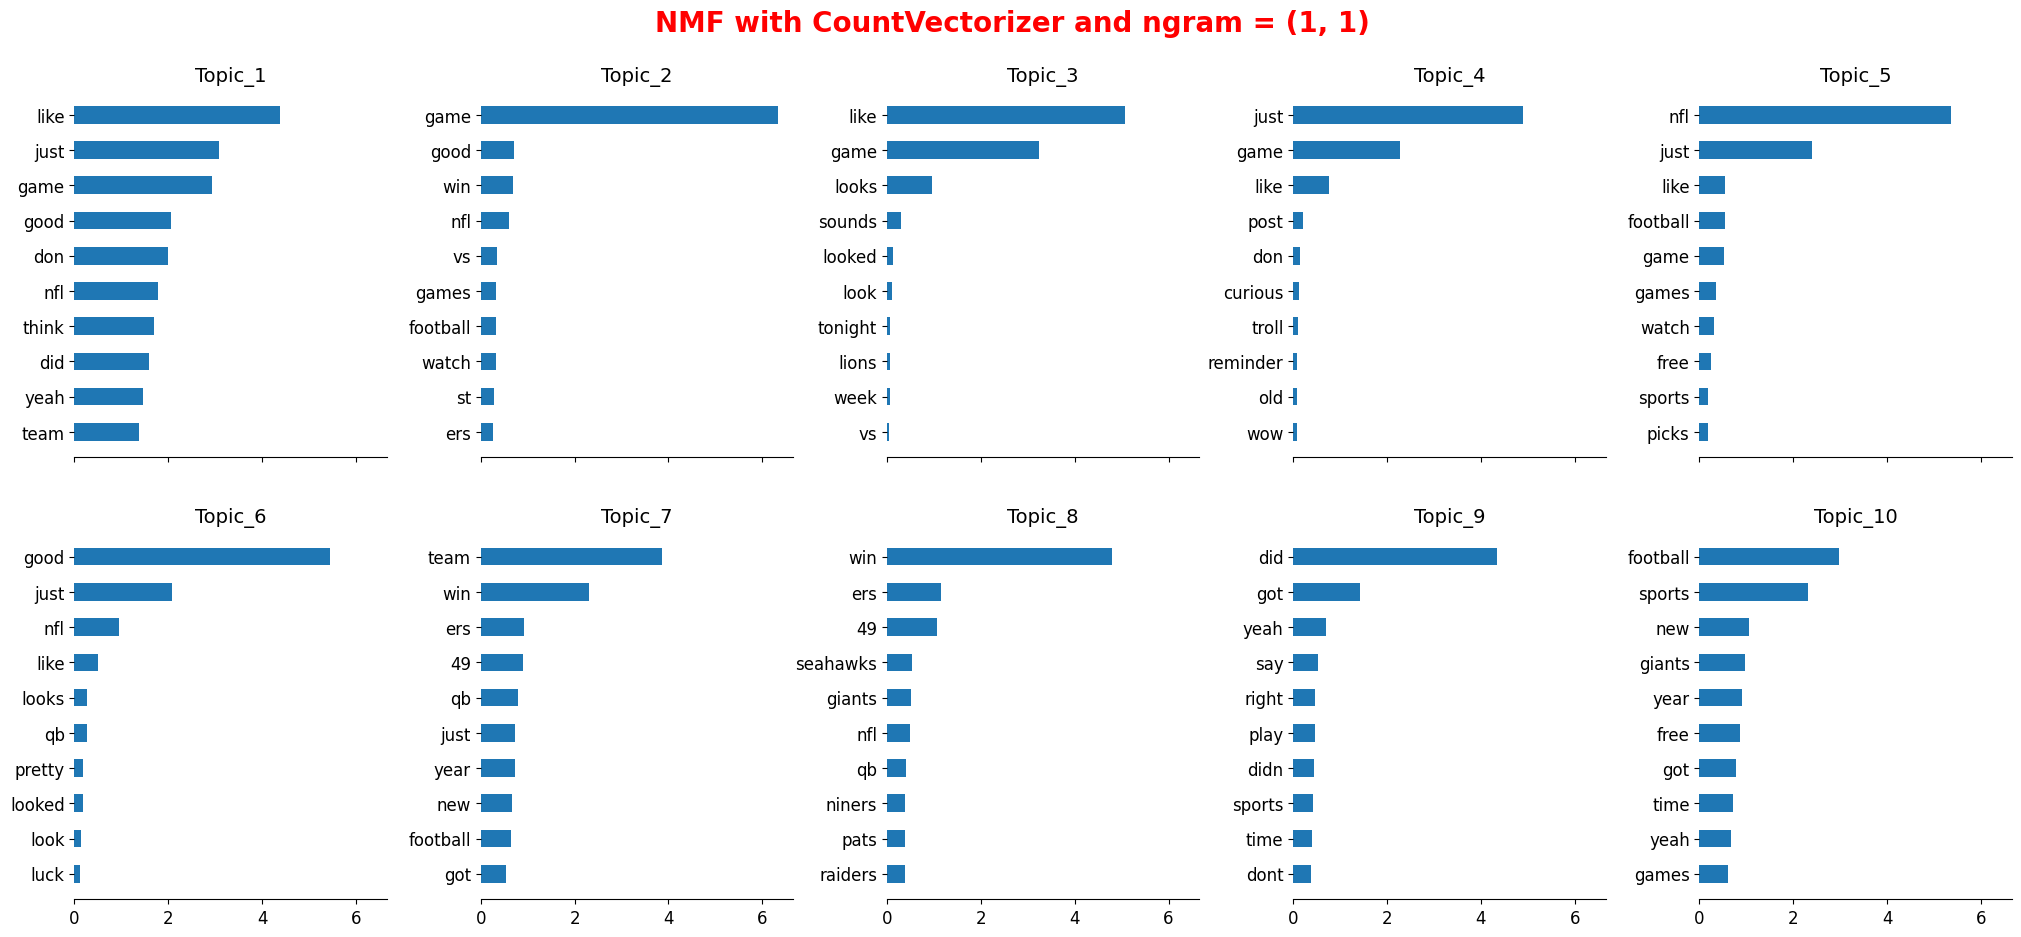

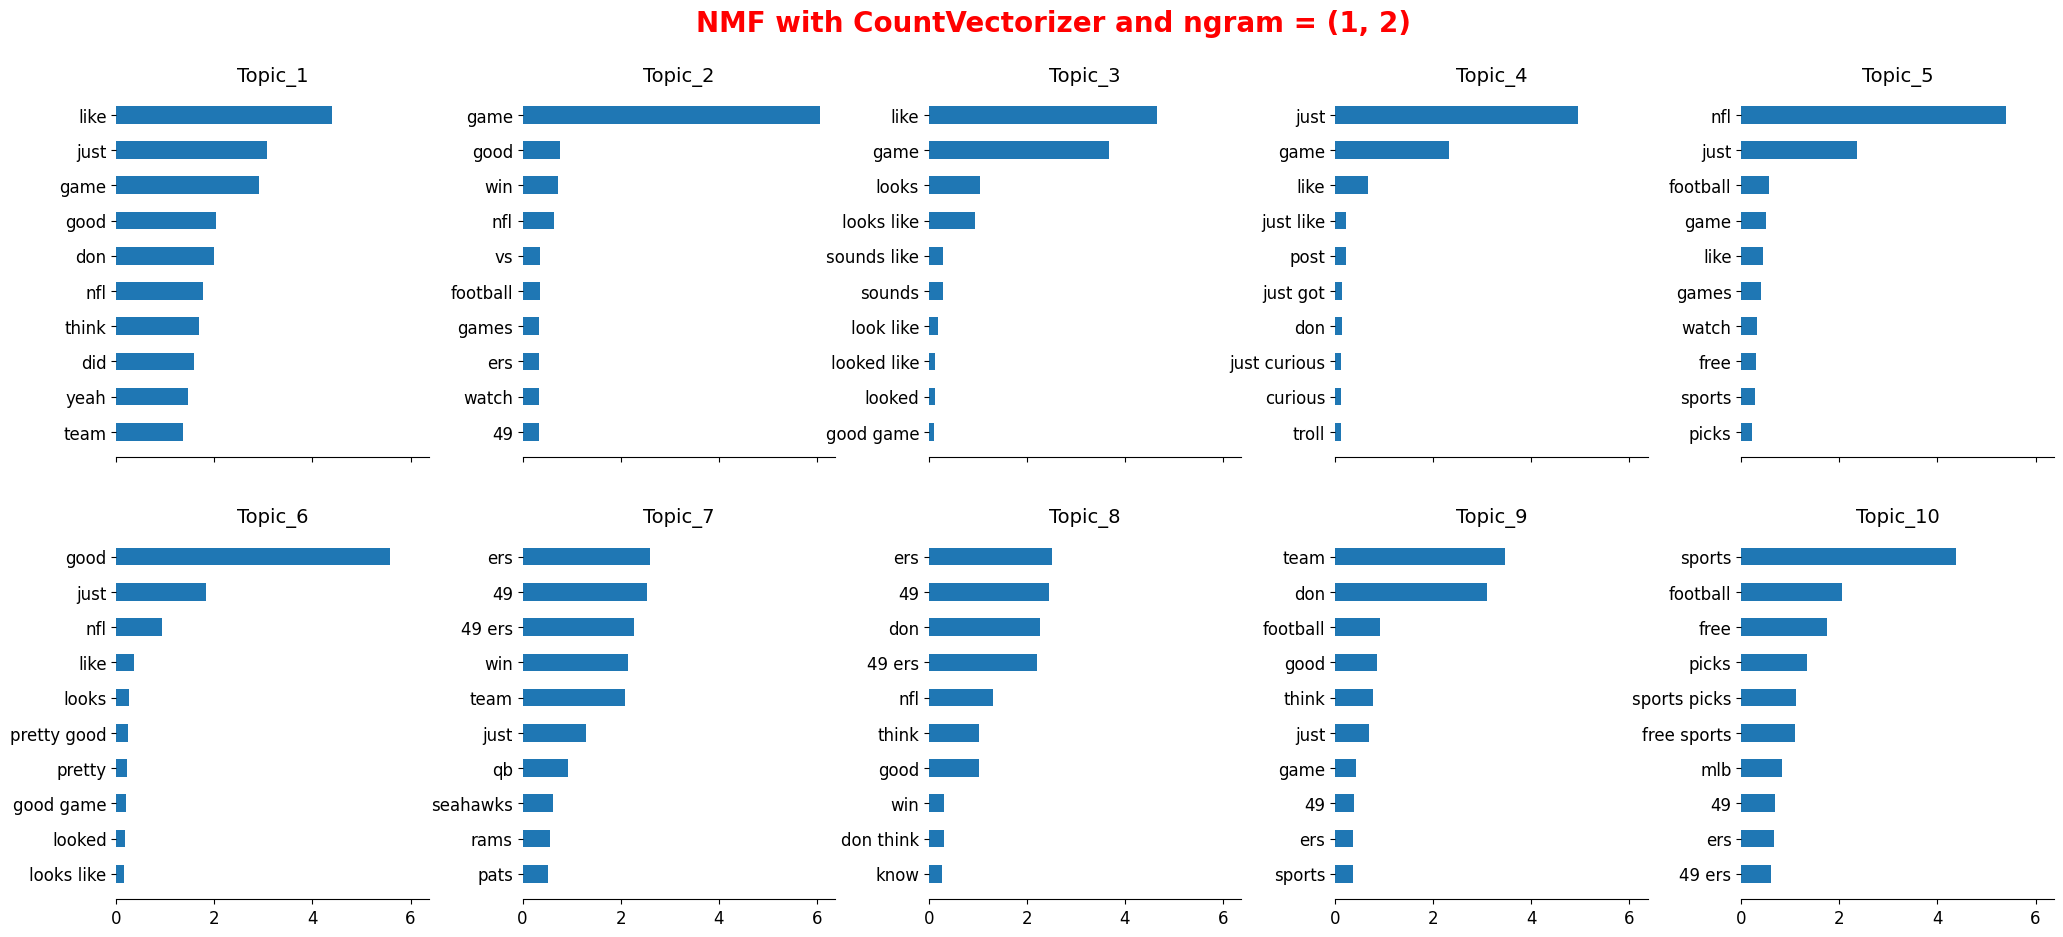

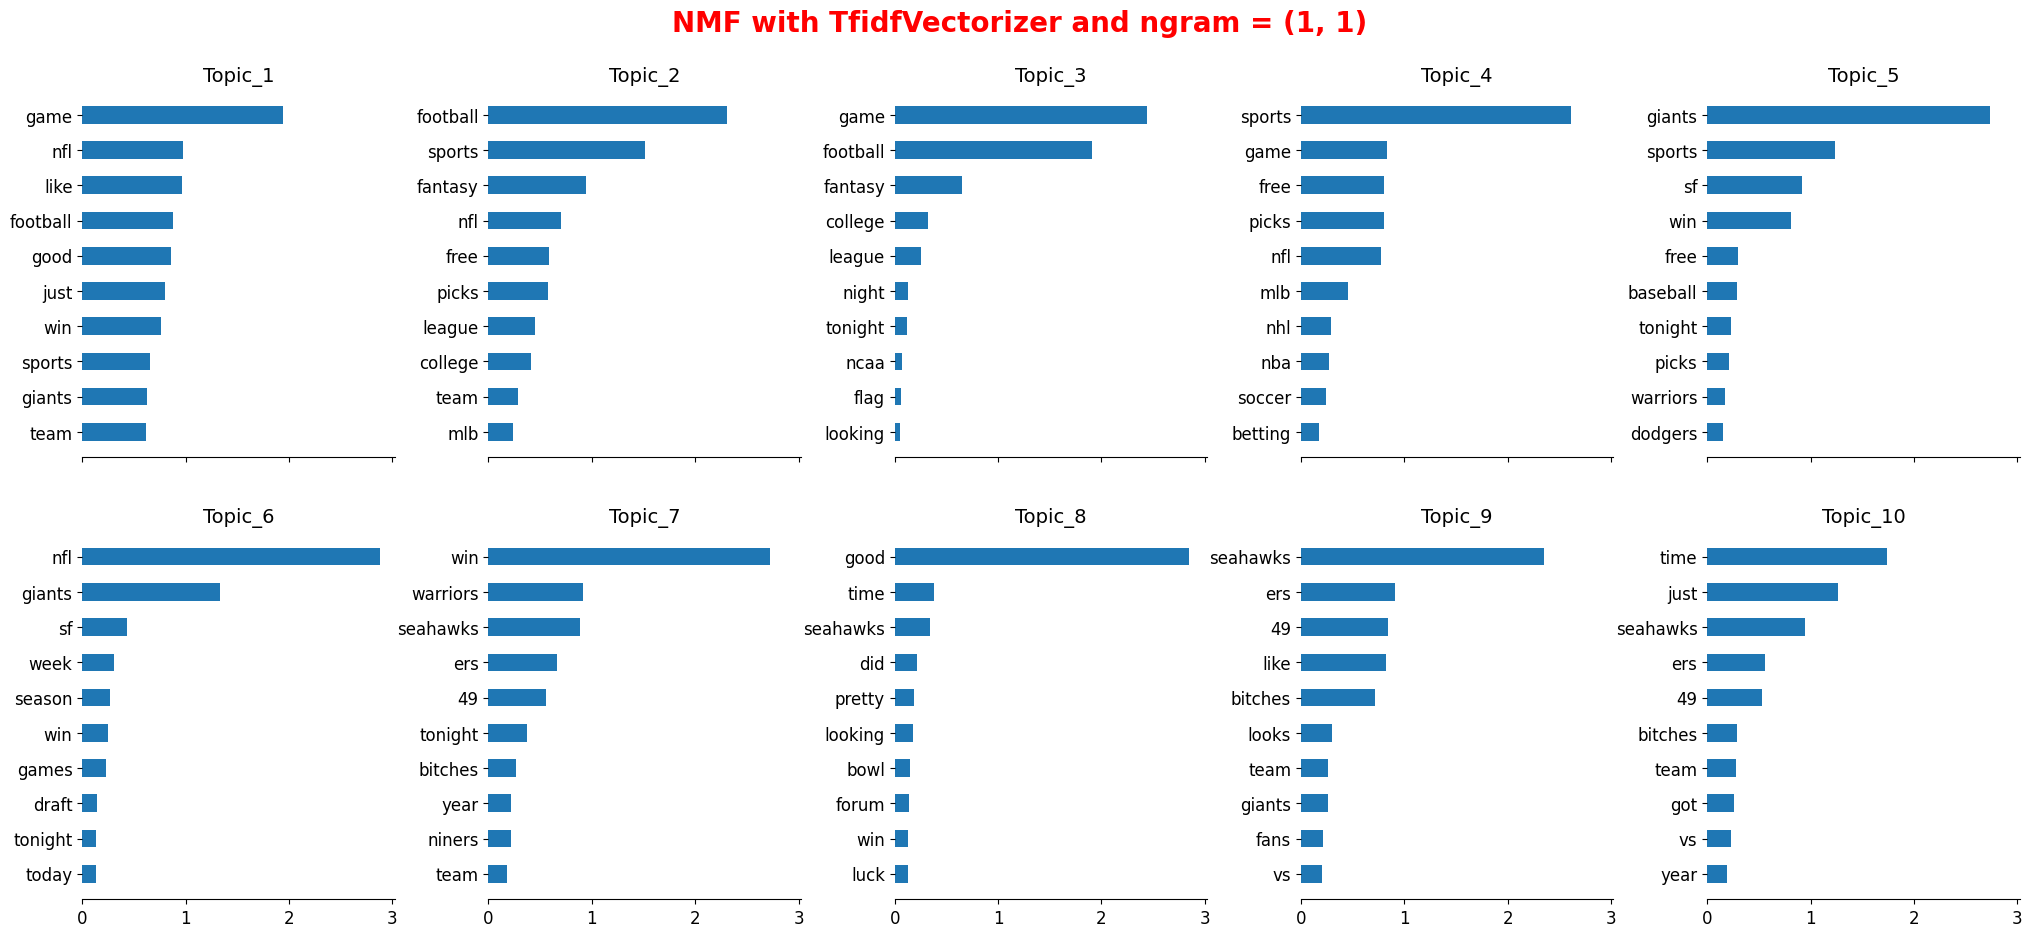

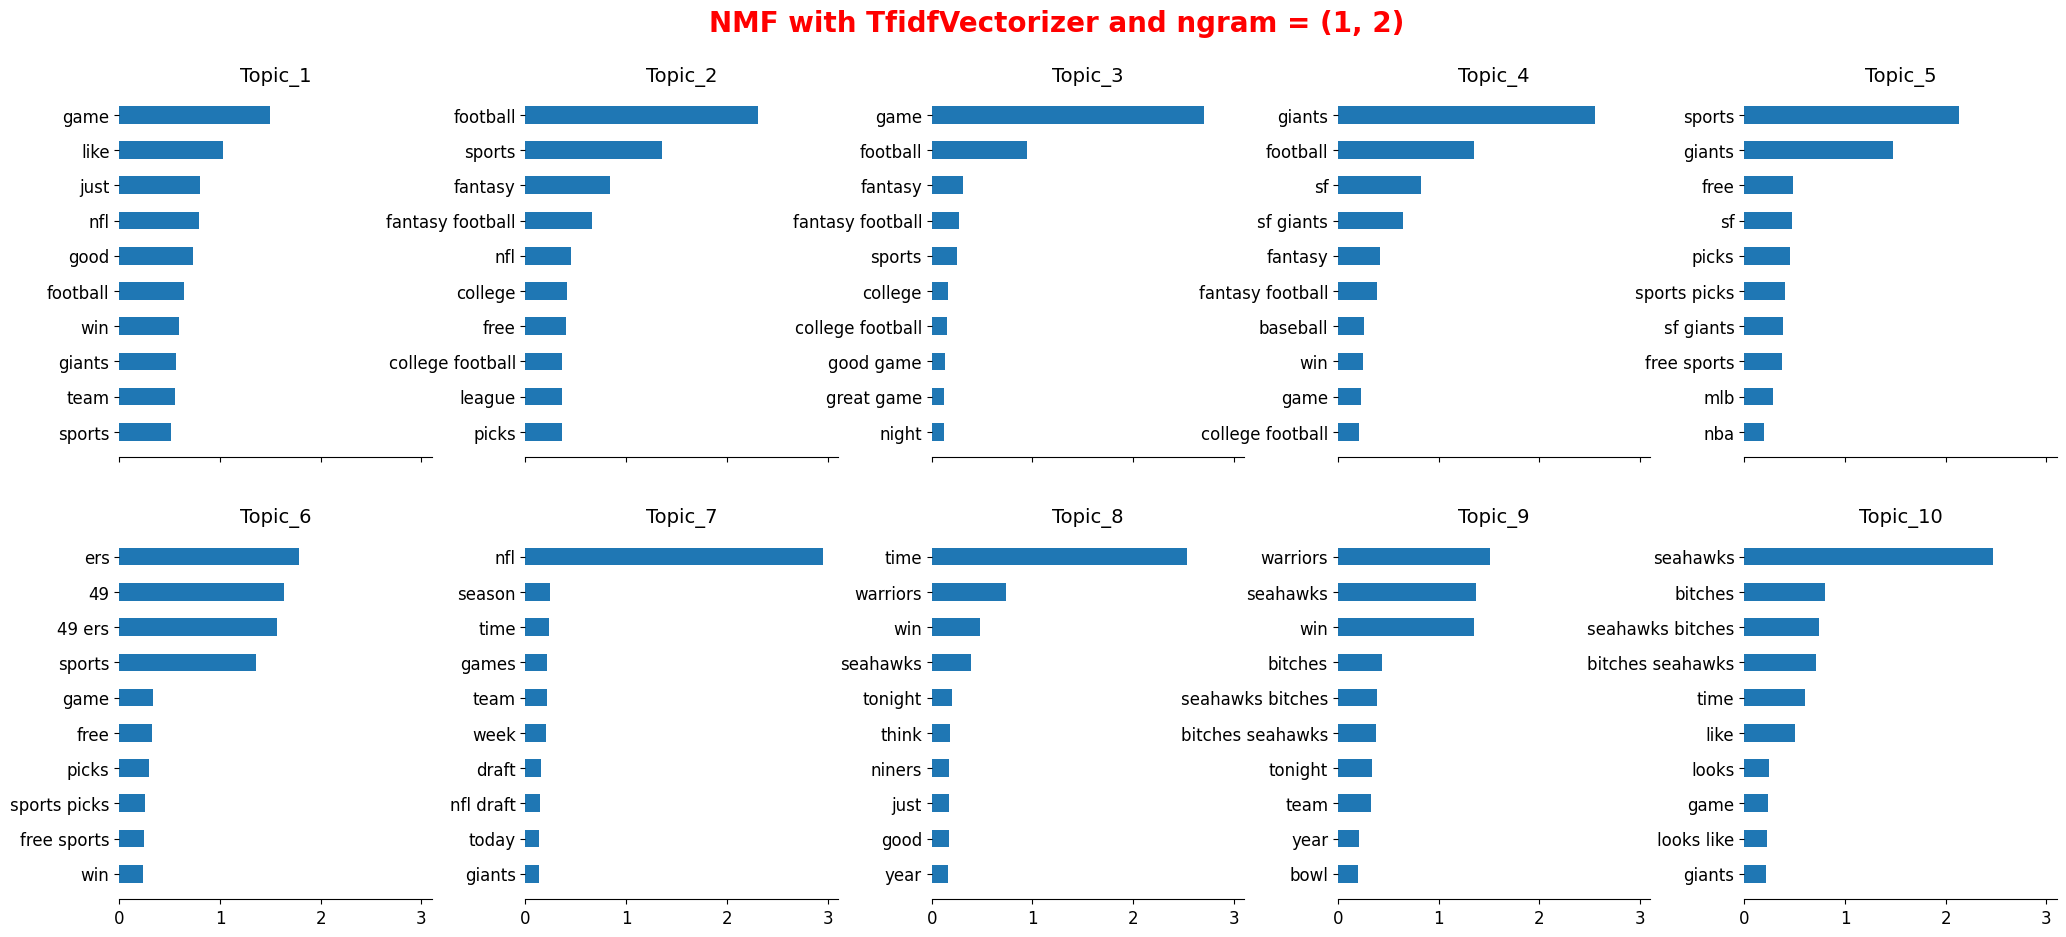

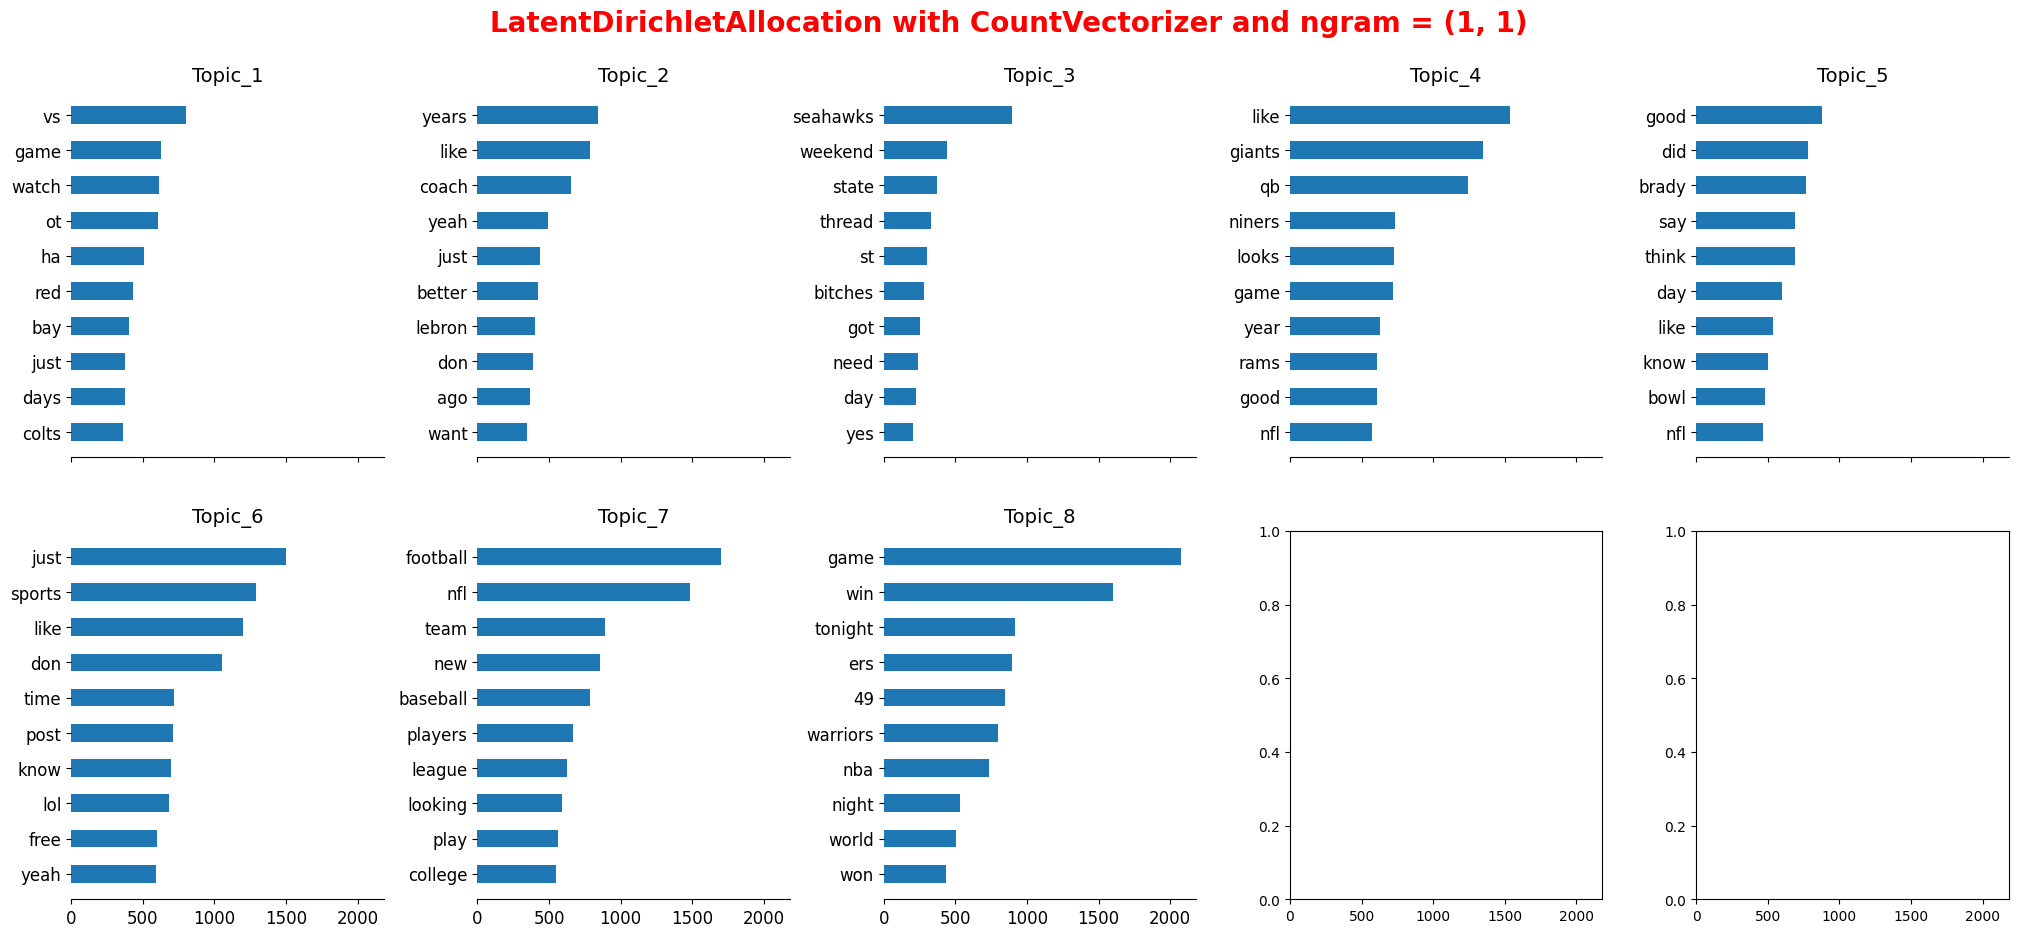

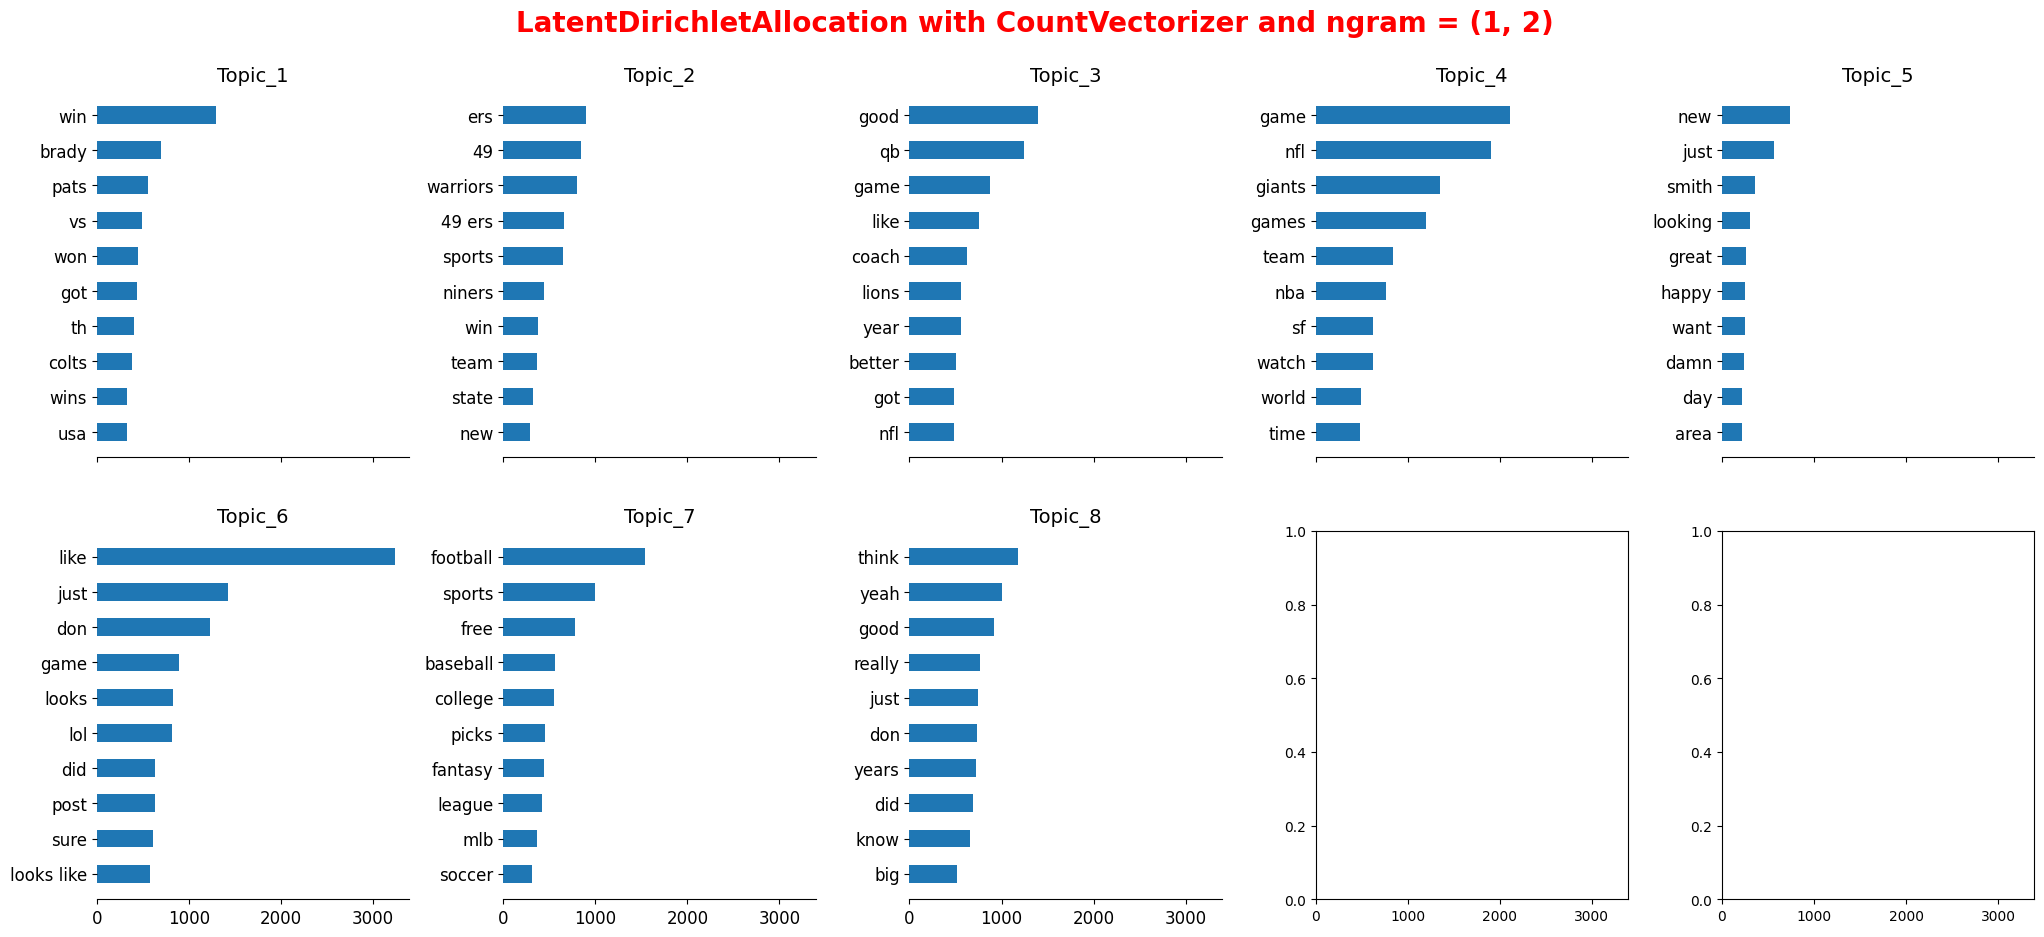

In [44]:
#plotting the results
for num in range(plot_results.shape[0]):
    model = plot_results.iloc[num]['model']
    vectorizer = plot_results.iloc[num]['vectorizers']
    ngram = plot_results.iloc[num]['ngrams']
    model_topics = plot_results.iloc[num]['top_topics']

    title = f"{model} with {vectorizer} and ngram = {ngram}"
    plot_top_results(model_topics, nrows=2, ncols=5, title=title)

#### Model results summary
Based on all the six models results, by coherence table, the countvectorizer performed better than Tfidfvectorizer while by ngram table, the bigram features outperformed the unigram features. For the NMF and LDA models, the coherence score for the countvectorizer of the bigram NMF model was approximately 0.68 while the counterpart countvetorizer of bigram LDA model scored 0.59. However looking at the reconstrunction error, the bigram features have significantly lower error but that is as expected when comparing bigram and unigram features. For the LDA models, the perplexity and log-likelihood values are very high showing that the models are struggling with each new document.  

Picking the two best coherence scoring models from NMF and LDA models which used countvectorizer and bigrams feature, and then the Tfidfvectorizer bigram NMF model aside and looking at their graph for topics: 
1. **NMF-countvectorizer-bigram**: the words 'game', 'good', 'like', 'just' were common in most of the topics with some words being two letter words.
2. **LDA-countvectorizer-bigram**: the words 'game', 'win', 'don' were across a few topics but the top words forming each topic are more distinct for each topic.
3. **NMF-Tfidfvectorizer-bigram**: the words 'football', 'fantasy', 'sports' were common and the words forming each topic were more similar compared to the countvectorizer. The coherence score for this model was 0.56.

Based on visual word similarity and topic interpretability from the plotted graphs, I am choosing NMF-tfidfvectorizer-bigram and LDA-countvectorizer-bigram to compare visually and side by side the topic similarity between the post and the all_reply data from the corpus

### post and reply comparision with LDA and NMF

In [45]:
### post data
post_X = post['post']
post_docs, post_dict = generate_token(post_X)

#post countvectoriser
post_ct, vect_post_ct = vectorizer_x(X=post_X, vectorizer=CountVectorizer, ngram=2)

## post tfidfvectorizer
post_tfidf, vect_post_tfidf = vectorizer_x(X=post_X, vectorizer=TfidfVectorizer, ngram=2)

### reply data
reply_X = reply['all_reply']
reply_docs, reply_dict = generate_token(reply_X)

# reply countvectorizer
reply_ct, reply_vect_ct = vectorizer_x(X=reply_X, vectorizer=CountVectorizer, ngram=2)

#reply tfidfvectorizer
reply_tfidf, vect_reply_tfidf = vectorizer_x(X=reply_X, vectorizer=TfidfVectorizer, ngram=2)


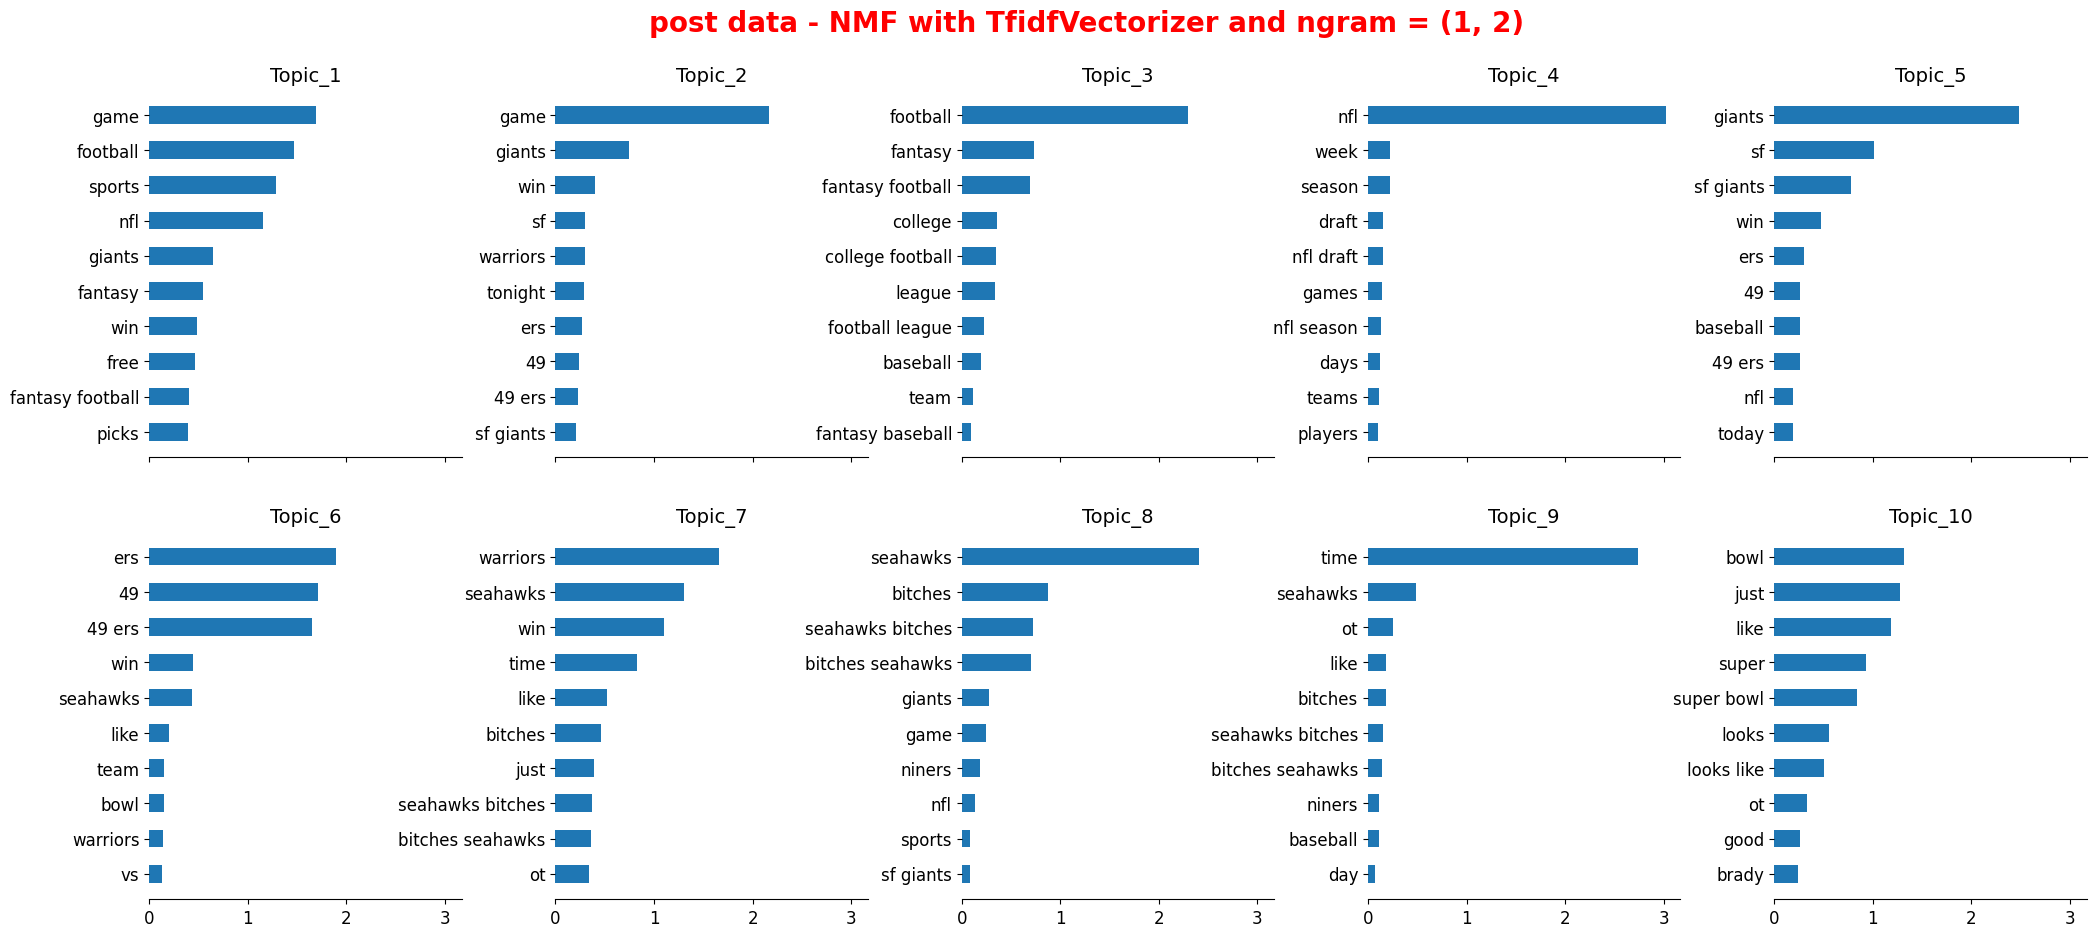

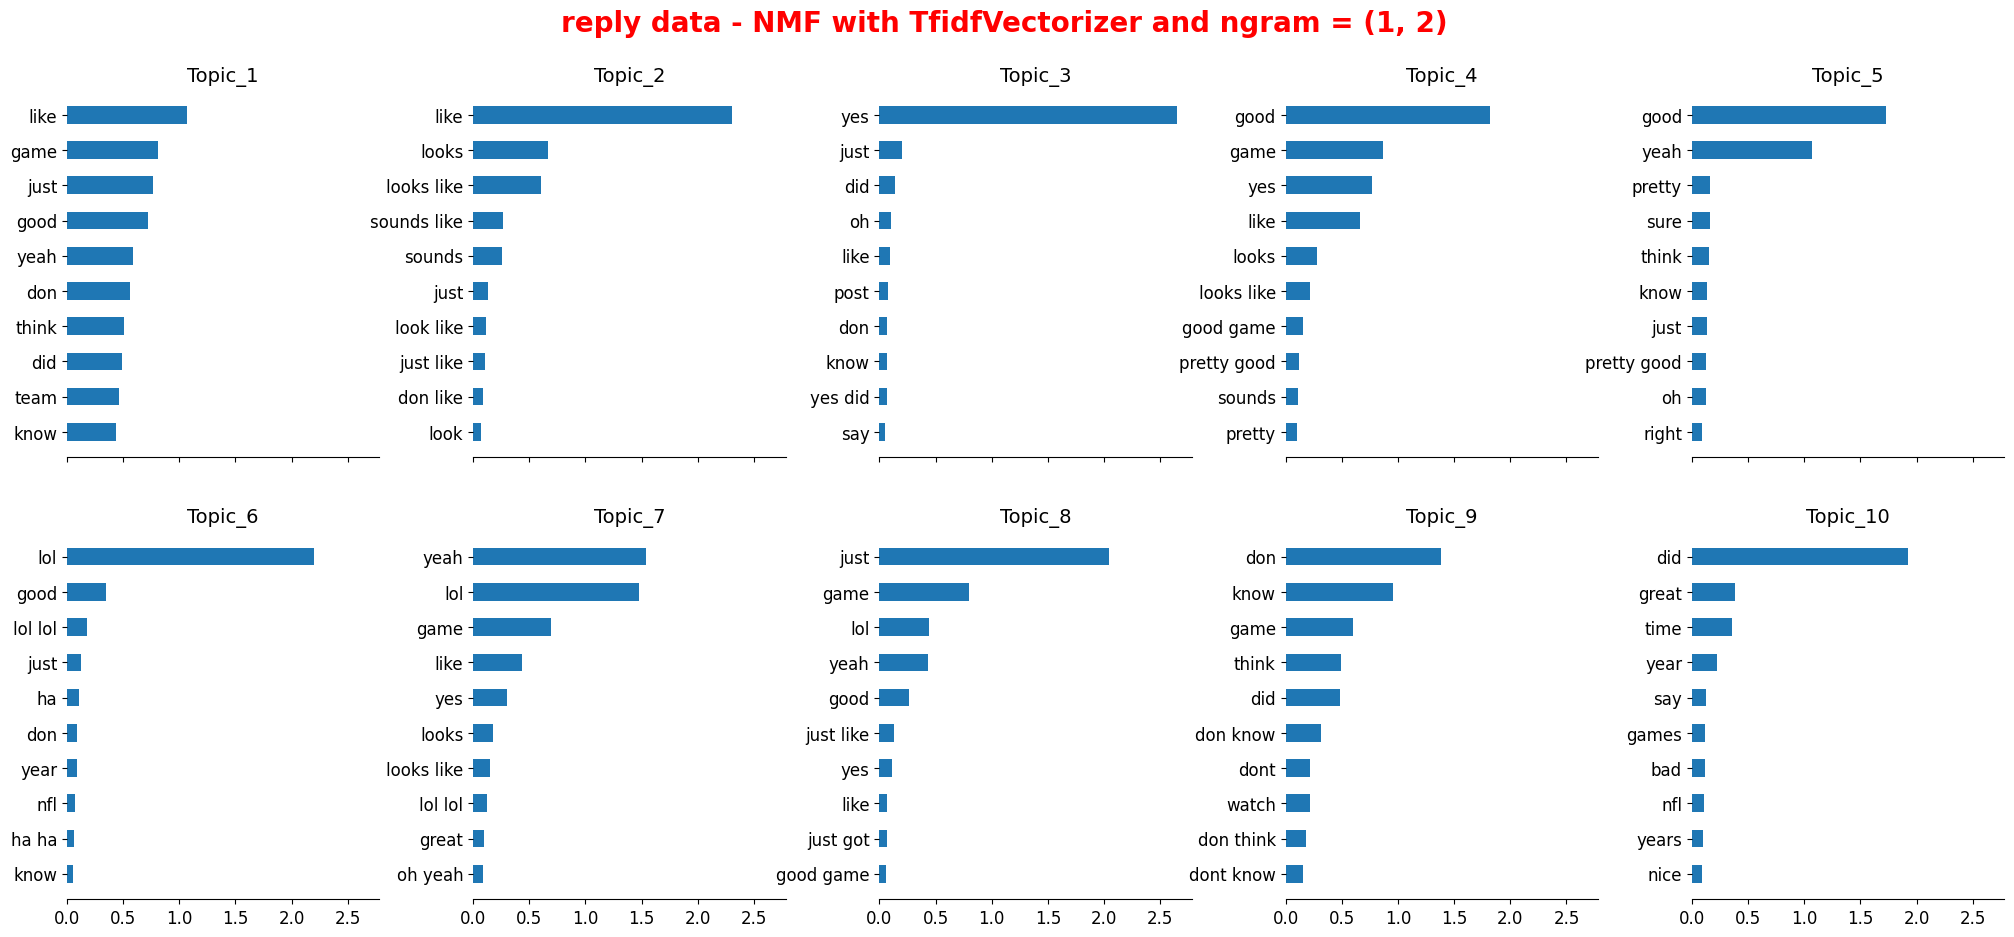

In [46]:
### comparion NMF models with tfidfvectorizer and bigram for post and reply dataset 

model_results = defaultdict(list)

#fiting post data
model_fit(model = best_NMF, X = post_tfidf, vect = vect_post_tfidf, token_docs = post_docs, token_dict = post_dict)
#fiting reply data
model_fit(model = best_NMF, X = reply_tfidf, vect = vect_reply_tfidf, token_docs = reply_docs, token_dict = reply_dict)

#isolating plotting keys
plot_keys = ['model', 'vectorizers', 'ngrams', 'top_topics']
#tabulating the plot results
plot_results = {}
for key in plot_keys:
    #plot_results.append(copy.deepcopy(model_results[key]))
    plot_results[key] = copy.deepcopy(model_results[key])
    
plot_results = pd.DataFrame(plot_results)

#plotting the results
data = ['post', 'reply']
for num in range(plot_results.shape[0]):
    
    model = plot_results.iloc[num]['model']
    vectorizer = plot_results.iloc[num]['vectorizers']
    ngram = plot_results.iloc[num]['ngrams']
    model_topics = plot_results.iloc[num]['top_topics']
    dataset = data[num]

    title = f"{dataset} data - {model} with {vectorizer} and ngram = {ngram}"
    plot_top_results(model_topics, nrows=2, ncols=5, title=title)

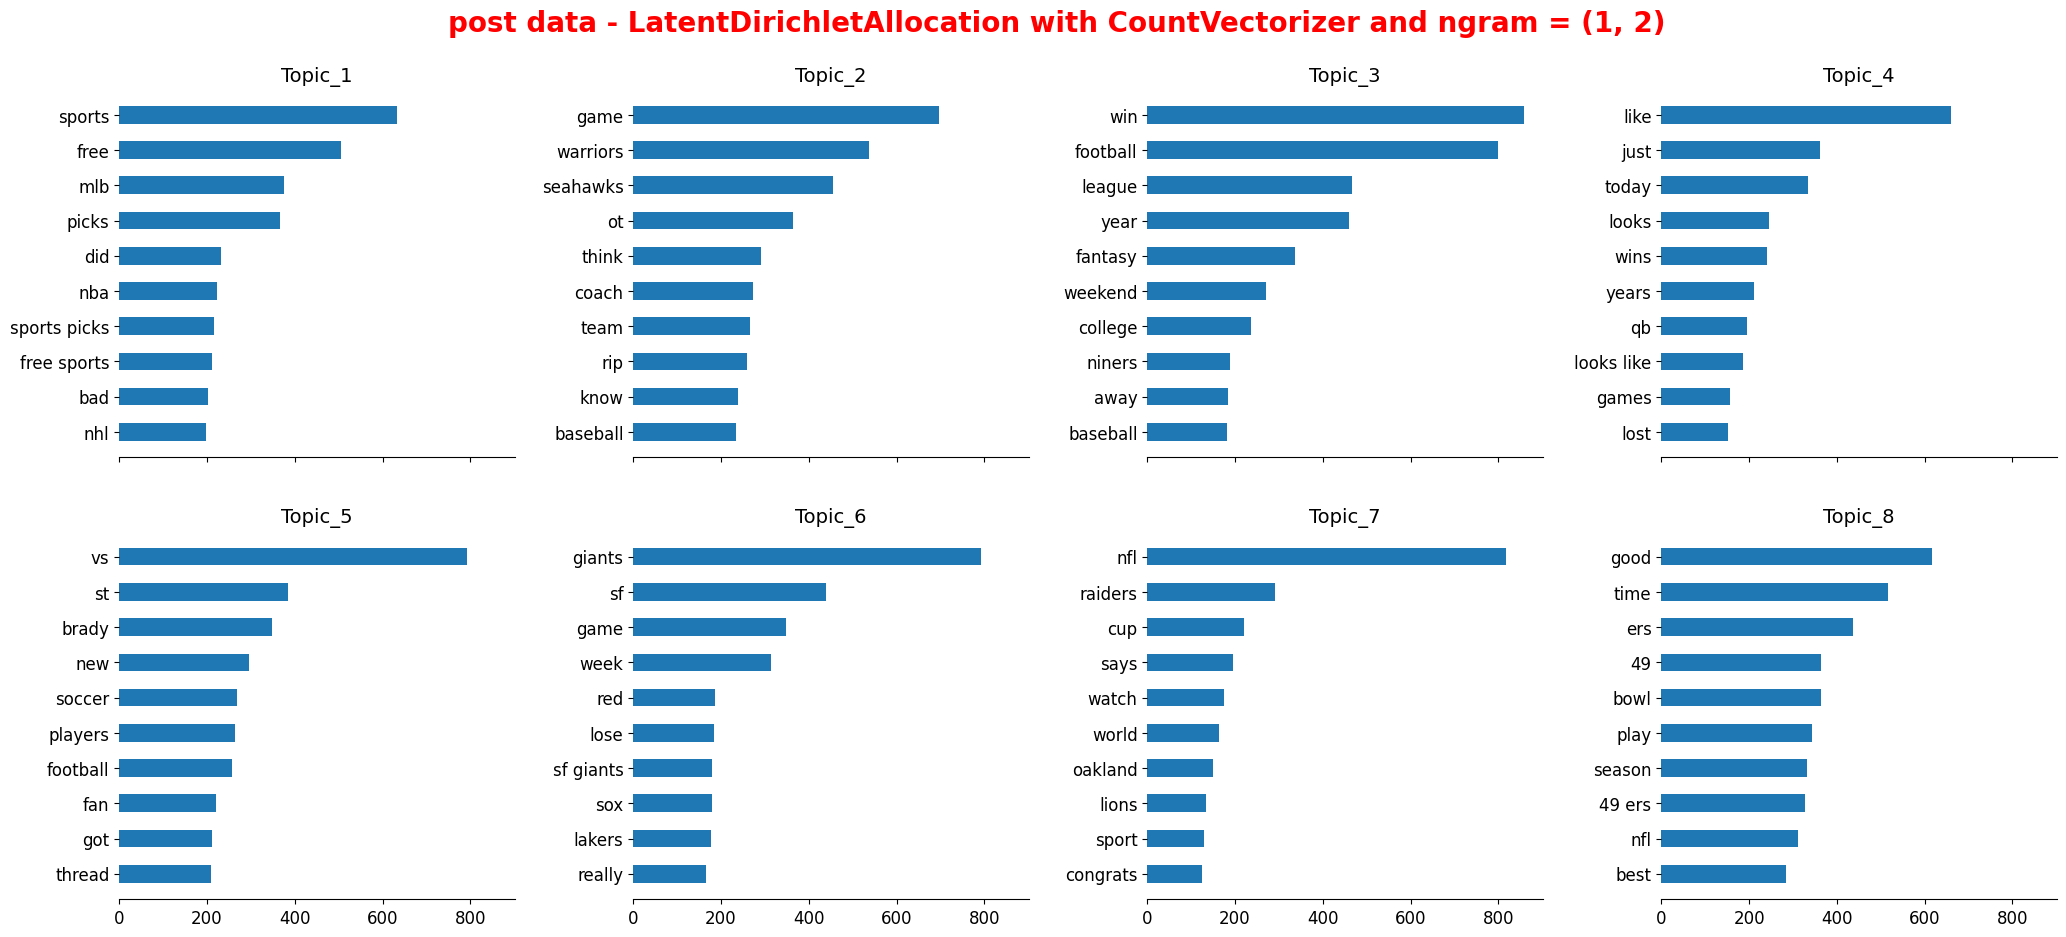

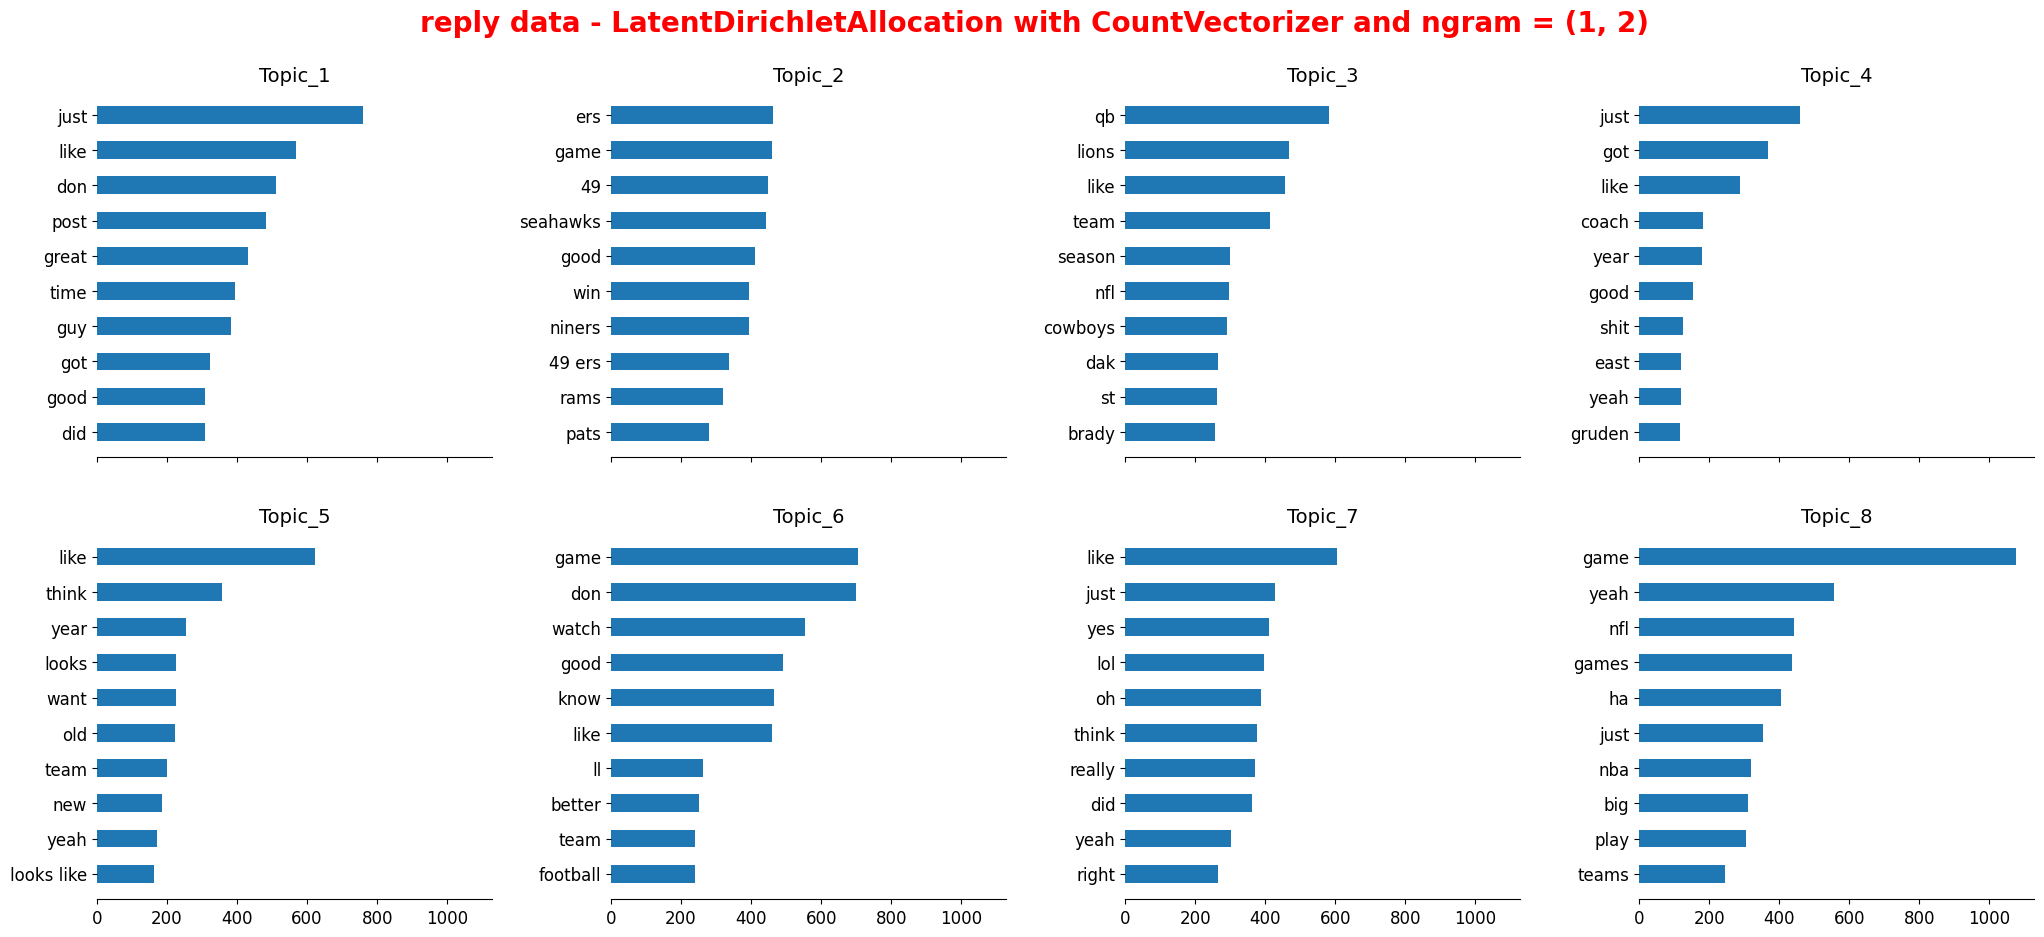

In [47]:
### comparion LDA models with countvectorizer and bigram for post and reply dataset 

model_results = defaultdict(list)

#fiting post data
model_fit(model = best_LDA, X = post_ct, vect = vect_post_ct, token_docs = post_docs, token_dict = post_dict)
#fiting reply data
model_fit(model = best_LDA, X = reply_ct, vect = reply_vect_ct, token_docs = reply_docs, token_dict = reply_dict)

#isolating plotting keys
plot_keys = ['model', 'vectorizers', 'ngrams', 'top_topics']
#tabulating the plot results
plot_results = {}
for key in plot_keys:
    #plot_results.append(copy.deepcopy(model_results[key]))
    plot_results[key] = copy.deepcopy(model_results[key])
    
plot_results = pd.DataFrame(plot_results)

#plotting the results
data = ['post', 'reply']
for num in range(plot_results.shape[0]):
    
    model = plot_results.iloc[num]['model']
    vectorizer = plot_results.iloc[num]['vectorizers']
    ngram = plot_results.iloc[num]['ngrams']
    model_topics = plot_results.iloc[num]['top_topics']
    dataset = data[num]

    title = f"{dataset} data - {model} with {vectorizer} and ngram = {ngram}"
    plot_top_results(model_topics, nrows=2, ncols=4, title=title)

#### post and reply comparison summary
There is significant dissimilarity between the topics in post data and reply data. Most topics in post data are sports related nouns while most topics in the reply data are verbs with less sports related nouns.  This disparity in post and reply data is not unexpected. One explanation to this is that post headings will often contain nouns relations to the topic of interest while most replies will be based on the topic of the post which is why there are more verbs in reply topics.

One more thing to observe is that in the combined data poltted earlier, the verbs in the topics were less obvious compared to when the post and reply data were separated, particularly for the Tfidfvectorizer NMF model.  This is an indication that the resultf of both the vectorization and modelling were good results

## Conclusion
In this topic modelling, I modelled the data from a sports forum discussion which contains post and reply columns. 
Two tuned models were chosen, LDA and NMF models. Data was modelled using both CountVectorizer and tfidfvectorizer prepared data. Countvectorizer performance was higher in NMF models due to lack of normalization. However, a tfidfvectorizer model from NMF and countvectorizer model from LDA were chosen to model the post and reply data separately. The post data showed sports focused topics while reply data showed verb focused topics. 